# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.21

analysis for dataset:

* dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_7\20220713-P_brain_CTP11-13_from_0418'

* rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors'

## in mendel
* save_folder = r'F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418' 


In [7]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

28444


In [8]:
test_im = ia.visual_tools.DaxReader(r'D:\MERFISH_Data\20221008-thymus_MOp_test\Hal_config_750s6_650s6_560s6_488s6_405s6_001_0.dax').loadAll()

In [9]:
bead_im = test_im[4::6]

In [11]:
from scipy.stats import scoreatpercentile

In [16]:
scoreatpercentile(bead_im, 99.999)

12522.468319952488

<IPython.core.display.Javascript object>


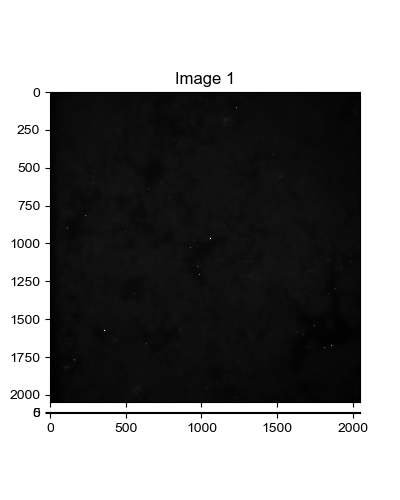

In [10]:
visual_tools.imshow_mark_3d_v2([bead_im])

## 0.1 Folders

In [2]:
save_folder = r'\\mendel\Mendel_SSD1\Pu_Temp\20220713-P_brain_CTP11-13_from_0418'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0709')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

184 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder
Use picked_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Picked_v0


# 1. Decoding of DNA-MERFISH

In [3]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-1000_codebook_probe_w_blanks.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mop_SE_1000_w_blanks.csv', header=0)

In [4]:
ctp11_codebook

name    id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0       1:3742742-3759944     1        0        0        0        0        0   
1       1:6245958-6258969     2        0        0        0        0        0   
2       1:8740008-8759916     3        0        0        0        0        0   
3     1:11247744-11257616     4        0        0        0        0        0   
4     1:13741888-13757922     5        0        0        0        0        0   
...                   ...   ...      ...      ...      ...      ...      ...   
1082              B:94-95  1157        0        0        0        0        0   
1083              B:95-96  1158        0        0        0        0        0   
1084              B:96-97  1159        0        0        0        0        0   
1085              B:97-98  1160        0        0        0        0        0   
1086              B:98-99  1161        0        0        0        0        0   

      NDB_725  NDB_817  NDB_710  ...  NDB_824  NDB_712  NDB_818  NDB_940  \
0           0        0        0  ...        0        0        0        0   
1           0        0        0  ...        0        0        0        0   
2           0        0        0  ...        0        0        0        0   
3           0        0        0  ...        0        0        0        1   
4           0        0        0  ...        0        0        1        0   
...       ...      ...      ...  ...      ...      ...      ...      ...   
1082        0        0        0  ...        0        0        0        0   
1083        0        0        0  ...        0        0        0        0   
1084        0        0        0  ...        0        0        0        0   
1085        0        0        0  ...        0        0        0        0   
1086        0        0        0  ...        0        0        0        0   

      NDB_872  NDB_934  NDB_926  NDB_910  chr  chr_order  
0           0        0        0        0    1        0.0  
1           0        0        0        0    1        1.0  
2           0        0        0        0    1        2.0  
3           0        0        0        0    1        3.0  
4           0        0        0        0    1        4.0  
...       ...      ...      ...      ...  ...        ...  
1082        0        0        0        0    B       94.0  
1083        0        0        0        0    B       95.0  
1084        1        0        0        0    B       96.0  
1085        0        0        0        0    B       97.0  
1086        0        0        0        0    B       98.0  

[1087 rows x 103 columns]

In [5]:
ctp13_codebook

name    id  NDB_376  NDB_578  NDB_400  NDB_533  NDB_568  \
0       1:9627926-9637875     1        0        0        0        1        0   
1       1:9799472-9811359     2        0        0        0        0        0   
2     1:20920666-20929358     3        0        0        0        0        0   
3     1:21522568-21534512     4        0        0        0        0        0   
4     1:21732182-21745770     5        0        0        0        0        0   
...                   ...   ...      ...      ...      ...      ...      ...   
1060            B:194-195  1086        0        0        0        0        0   
1061            B:195-196  1087        0        0        0        0        1   
1062            B:196-197  1088        0        0        1        0        0   
1063            B:197-198  1089        0        0        0        0        0   
1064            B:198-199  1090        1        0        0        0        0   

      NDB_464  NDB_466  NDB_431  ...  NDB_608  NDB_460  NDB_563  NDB_592  \
0           0        0        0  ...        0        0        0        0   
1           0        0        0  ...        0        0        0        1   
2           0        0        0  ...        1        0        0        0   
3           0        0        0  ...        0        0        0        0   
4           0        0        0  ...        0        0        0        0   
...       ...      ...      ...  ...      ...      ...      ...      ...   
1060        0        0        0  ...        0        0        0        0   
1061        0        0        0  ...        0        0        0        0   
1062        0        0        0  ...        0        0        0        0   
1063        0        0        0  ...        0        0        0        0   
1064        0        0        0  ...        0        0        0        0   

      NDB_368  NDB_436  NDB_629  NDB_604  chr  chr_order  
0           0        0        0        0    1        0.0  
1           0        0        0        0    1        1.0  
2           0        0        0        0    1        2.0  
3           0        0        0        0    1        3.0  
4           0        0        0        0    1        4.0  
...       ...      ...      ...      ...  ...        ...  
1060        0        0        0        0    B       94.0  
1061        0        0        0        0    B       95.0  
1062        0        0        0        0    B       96.0  
1063        0        0        1        0    B       97.0  
1064        0        0        0        0    B       98.0  

[1065 rows x 99 columns]

## Load bit_2_name

In [6]:
readout_df_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_combo_readouts.csv')
readout_df_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mouse-SE_combo_readouts.csv')

# merge
readout_df_se['Bit']+=100
readout_df = pd.concat([readout_df_gn, readout_df_se])
readout_df

Bit ReadoutName
0     1     NDB_784
1     2     NDB_755
2     3     NDB_826
3     4     NDB_713
4     5     NDB_865
..  ...         ...
90  191     NDB_592
91  192     NDB_368
92  193     NDB_436
93  194     NDB_629
94  195     NDB_604

[194 rows x 2 columns]

In [7]:
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = True
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25

## 3.3 prepare kwargs to decode CTP11

In [8]:
%%time

ctp11_data_type = 'combo'
ctp11_lib_name = 'CTP11'
ctp11_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp11_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp11_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp11_decode_args.append(
            (ctp11_lib_name, _cell_spots_df, ctp11_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp11_decode_args))

- Preparing decoding args for fov: 0, 184
- Preparing decoding args for fov: 1, 326
- Preparing decoding args for fov: 2, 471
- Preparing decoding args for fov: 3, 610
- Preparing decoding args for fov: 4, 779
- Preparing decoding args for fov: 5, 952
- Preparing decoding args for fov: 6, 1081
- Preparing decoding args for fov: 7, 1208
- Preparing decoding args for fov: 8, 1352
- Preparing decoding args for fov: 9, 1487
- Preparing decoding args for fov: 10, 1613
- Preparing decoding args for fov: 11, 1724
- Preparing decoding args for fov: 12, 1864
- Preparing decoding args for fov: 13, 1991
- Preparing decoding args for fov: 14, 2133
- Preparing decoding args for fov: 15, 2321
- Preparing decoding args for fov: 16, 2512
- Preparing decoding args for fov: 18, 2626
- Preparing decoding args for fov: 19, 2749
- Preparing decoding args for fov: 20, 2889
- Preparing decoding args for fov: 21, 2990
- Preparing decoding args for fov: 22, 3073
- Preparing decoding args for fov: 23, 3165
- Pr

## Test decoding for one cell

In [17]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 500

# conbinatorial
batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
#batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Matching 194 bits to (988, 103) codebook
-- 99 bits matched
- Process (988, 102) codebook into valid pairs
-- 2964 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- filter candidate pairs by codebook
-- 26806 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


 41%|████████████████████████████████▎                                             | 11114/26806 [00:00<00:00, 111057.23it/s]

-- 2914 full tuples selected


100%|██████████████████████████████████████████████████████████████████████████████| 26806/26806 [00:00<00:00, 116461.02it/s]


-- 2355 pairs selected
-- in total 5269 spot_groups detected
- Save decoder of CTP11 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder\Decoded_fov-3_cell-30.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:389: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  _spotGroupDf.to_hdf(self.saveFile, f'{self.codebook_name}/spotGroups', complevel=_complevel, complib=_complib)


- Save spot_stats iamage to file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder\Decoded_fov-3_cell-30_CTP11_stats.png


## Plot decoded spots

In [18]:
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')

matplotlib.rcParams['pdf.fonttype'] = 42

In [19]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D_figures')
print(decoded_figure_folder)
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder\Decoded_3D_figures


<IPython.core.display.Javascript object>


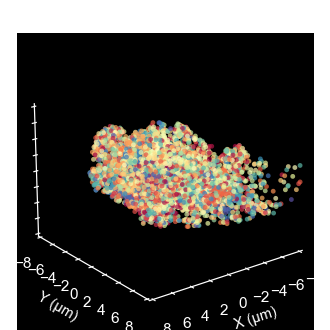

In [20]:
%matplotlib notebook
sel_lib = 'CTP11'
_decoded_groups = pd.read_hdf(ctp11_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

# Process All

In [9]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp11_decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp11_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

21883
Wall time: 1h 43min 38s


In [15]:
# Delete args to release RAM
del(ctp11_decode_args)
del(decode_results)

## 3.4 prepare kwargs to decode CTP13

In [10]:
%%time
ctp13_data_type = 'combo'
ctp13_lib_name = 'CTP13'
ctp13_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp13_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            (ctp13_lib_name, _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp13_decode_args))

- Preparing decoding args for fov: 0, 184
- Preparing decoding args for fov: 1, 326
- Preparing decoding args for fov: 2, 471
- Preparing decoding args for fov: 3, 610
- Preparing decoding args for fov: 4, 779
- Preparing decoding args for fov: 5, 952
- Preparing decoding args for fov: 6, 1081
- Preparing decoding args for fov: 7, 1208
- Preparing decoding args for fov: 8, 1352
- Preparing decoding args for fov: 9, 1487
- Preparing decoding args for fov: 10, 1613
- Preparing decoding args for fov: 11, 1724
- Preparing decoding args for fov: 12, 1864
- Preparing decoding args for fov: 13, 1991
- Preparing decoding args for fov: 14, 2133
- Preparing decoding args for fov: 15, 2321
- Preparing decoding args for fov: 16, 2512
- Preparing decoding args for fov: 18, 2626
- Preparing decoding args for fov: 19, 2749
- Preparing decoding args for fov: 20, 2889
- Preparing decoding args for fov: 21, 2990
- Preparing decoding args for fov: 22, 3073
- Preparing decoding args for fov: 23, 3165
- Pr

## Test decoding the same cell

In [23]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder

# conbinatorial
#batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Matching 194 bits to (966, 99) codebook
-- 95 bits matched
- Process (966, 98) codebook into valid pairs
-- 2898 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 26748 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


 99%|█████████████████████████████████████████████████████████████████████████████▎| 26512/26748 [00:00<00:00, 134396.07it/s]

-- 2772 full tuples selected


100%|██████████████████████████████████████████████████████████████████████████████| 26748/26748 [00:00<00:00, 131665.00it/s]


-- 2303 pairs selected
-- in total 5075 spot_groups detected
- Save decoder of CTP13 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder\Decoded_fov-3_cell-30.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:389: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  _spotGroupDf.to_hdf(self.saveFile, f'{self.codebook_name}/spotGroups', complevel=_complevel, complib=_complib)


- Save spot_stats iamage to file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder\Decoded_fov-3_cell-30_CTP13_stats.png


<IPython.core.display.Javascript object>


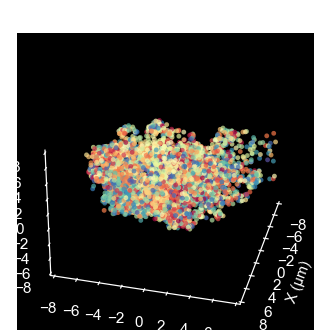

In [24]:
%matplotlib notebook
sel_lib = 'CTP13'
_decoded_groups = pd.read_hdf(ctp13_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp13_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

## Process ALL

In [11]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp13_decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp13_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

21883
Wall time: 1h 43min 18s


In [18]:
# Delete args to release RAM
del(ctp13_decode_args)
del(decode_results)

# 5. CTP12, sequential TSS for markergenes

## 5.1 prepare kwargs to map sequential CTP12

In [12]:
ctp12_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_sequential-codebook.csv', header=0)
ctp12_codebook

name       id chr  Stv_91  Stv_32  Stv_92  Stv_33  \
0      5:31098237-31118237  Slc30a3   5       1       0       0       0   
1      7:45153949-45173949  Slc17a7   7       0       1       0       0   
2    2:158600767-158620767  Slc32a1   2       0       0       1       0   
3      2:70543072-70563072     Gad1   2       0       0       0       1   
4      5:30451932-30471932     Otof   5       0       0       0       0   
5    4:124976430-124996430    Rspo1   4       0       0       0       0   
6     15:78196400-78216400    Pvalb  15       0       0       0       0   
7     16:23880958-23900958      Sst  16       0       0       0       0   
8       10:5629218-5649218      Vip  10       0       0       0       0   
9     14:34364789-34384789     Sncg  14       0       0       0       0   
10   2:136042239-136062239    Lamp5   2       0       0       0       0   
11    15:60843778-60863778   Lratd2  15       0       0       0       0   
12   2:169623013-169643013    Tshz2   2       0       0       0       0   
13   3:103565231-103585231     Syt6   3       0       0       0       0   
14  10:127524559-127544559    Nxph4  10       0       0       0       0   
15   5:122040102-122060102     Cux2   5       0       0       0       0   
16    19:19101196-19121196     Rorb  19       0       0       0       0   
17   2:166145663-166165663    Sulf2   2       0       0       0       0   
18   4:131828288-131848288    Ptpru   4       0       0       0       0   
19     3:14853512-14873512     Car3   3       0       0       0       0   
20    18:15400982-15420982     Aqp4  18       0       0       0       0   
21   5:147716011-147736011     Flt1   5       0       0       0       0   
22   7:142656816-142676816     Igf2   7       0       0       0       0   
23     5:75142292-75162292   Pdgfra   5       0       0       0       0   
24    15:79155240-79175240    Sox10  15       0       0       0       0   
25     3:95516786-95536786     Ctss   3       0       0       0       0   
26    11:78489091-78509091      Vtn  11       0       0       0       0   
27     X:73473602-73493602      Bgn   X       0       0       0       0   

    Stv_94  Stv_35  Stv_95  ...  Stv_106  Stv_45  Stv_107  Stv_46  Stv_109  \
0        0       0       0  ...        0       0        0       0        0   
1        0       0       0  ...        0       0        0       0        0   
2        0       0       0  ...        0       0        0       0        0   
3        0       0       0  ...        0       0        0       0        0   
4        1       0       0  ...        0       0        0       0        0   
5        0       1       0  ...        0       0        0       0        0   
6        0       0       1  ...        0       0        0       0        0   
7        0       0       0  ...        0       0        0       0        0   
8        0       0       0  ...        0       0        0       0        0   
9        0       0       0  ...        0       0        0       0        0   
10       0       0       0  ...        0       0        0       0        0   
11       0       0       0  ...        0       0        0       0        0   
12       0       0       0  ...        0       0        0       0        0   
13       0       0       0  ...        0       0        0       0        0   
14       0       0       0  ...        0       0        0       0        0   
15       0       0       0  ...        0       0        0       0        0   
16       0       0       0  ...        0       0        0       0        0   
17       0       0       0  ...        0       0        0       0        0   
18       0       0       0  ...        1       0        0       0        0   
19       0       0       0  ...        0       1        0       0        0   
20       0       0       0  ...        0       0        1       0        0   
21       0       0       0  ...        0       0        0       1        0   
22       0       0       0  ...        0       0    

In [13]:
ctp12_readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_unique_readouts.csv', header=0)
ctp12_readout_df

Bit ReadoutName
0     1      Stv_91
1     2      Stv_32
2     3      Stv_92
3     4      Stv_33
4     5      Stv_94
5     6      Stv_35
6     7      Stv_95
7     8      Stv_36
8     9      Stv_99
9    10      Stv_37
10   11     Stv_100
11   12      Stv_39
12   13     Stv_101
13   14      Stv_40
14   15     Stv_104
15   16      Stv_42
16   17     Stv_105
17   18      Stv_44
18   19     Stv_106
19   20      Stv_45
20   21     Stv_107
21   22      Stv_46
22   23     Stv_109
23   24      Stv_48
24   25     Stv_118
25   26      Stv_50
26   27     Stv_119
27   28      Stv_53

In [14]:
%%time
from ImageAnalysis3.classes import new_decoder
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper


ctp12_lib_name = 'CTP12tss'
ctp12_data_type = 'unique'
ctp12_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp12_lib_name in _f.keys():
                    continue

        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp12_decode_args.append(
            (ctp12_lib_name, _cell_spots_df, ctp12_codebook, ctp12_readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp12_decode_args))
    

- Preparing decoding args for fov: 0, 182
- Preparing decoding args for fov: 1, 324
- Preparing decoding args for fov: 2, 468
- Preparing decoding args for fov: 3, 606
- Preparing decoding args for fov: 4, 774
- Preparing decoding args for fov: 5, 946
- Preparing decoding args for fov: 6, 1074
- Preparing decoding args for fov: 7, 1201
- Preparing decoding args for fov: 8, 1335
- Preparing decoding args for fov: 9, 1460
- Preparing decoding args for fov: 10, 1583
- Preparing decoding args for fov: 11, 1693
- Preparing decoding args for fov: 12, 1831
- Preparing decoding args for fov: 13, 1956
- Preparing decoding args for fov: 14, 2097
- Preparing decoding args for fov: 15, 2284
- Preparing decoding args for fov: 16, 2474
- Preparing decoding args for fov: 18, 2588
- Preparing decoding args for fov: 19, 2710
- Preparing decoding args for fov: 20, 2846
- Preparing decoding args for fov: 21, 2945
- Preparing decoding args for fov: 22, 3028
- Preparing decoding args for fov: 23, 3120
- Pr

## Process ALL

In [15]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

In [16]:
%%time
print(len(ctp12_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotMapper, ctp12_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

21076
Wall time: 4min 31s


## load decoded results

In [18]:
sel_col = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']
sel_cell = 500
sel_filename = ctp13_decode_args[sel_cell][4]

ctp11_decoded_df = pd.read_hdf(sel_filename, 'CTP11/spotGroups')[sel_col]
ctp13_decoded_df = pd.read_hdf(sel_filename, 'CTP13/spotGroups')[sel_col]

ctp12_decoded_df = pd.read_hdf(sel_filename, 'CTP12tss/candSpots')[sel_col]

## 3D rendering of decoded spots

In [19]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D')
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

In [20]:
from matplotlib import animation
plot_animation = True
angle = 3

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
figure_width = _double_col_width
figure_dpi=100
background_color = [0,0,0]
marker_size = 8
marker_alpha = 1

depthshade=False

<IPython.core.display.Javascript object>


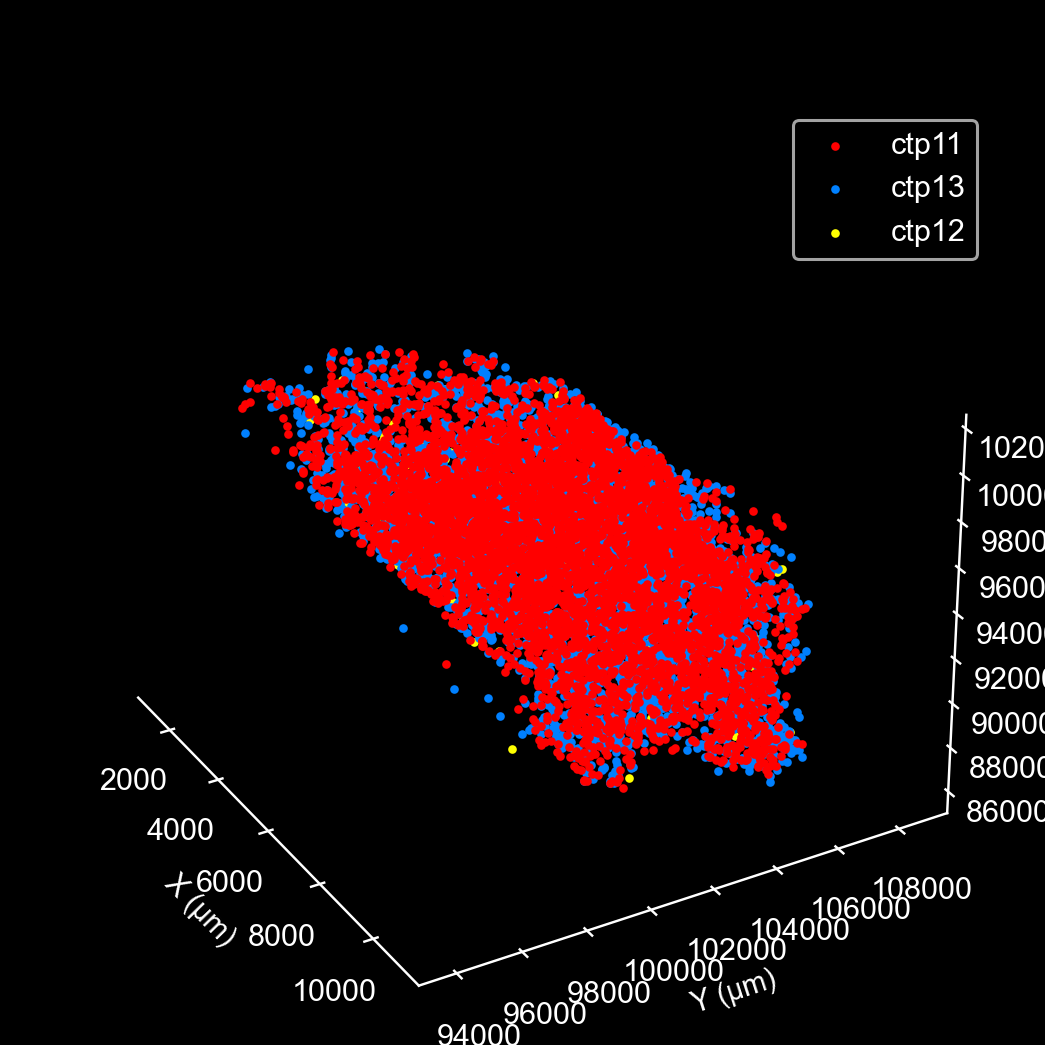

In [23]:
%matplotlib notebook
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')
fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

#"ctp11"
_sc = ax3d.scatter(ctp11_decoded_df['center_z'], ctp11_decoded_df['center_x'], ctp11_decoded_df['center_y'], 
                   color=[1,0,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp11')
#"ctp13"
_sc = ax3d.scatter(ctp13_decoded_df['center_z'], ctp13_decoded_df['center_x'], ctp13_decoded_df['center_y'], 
                   color=[0,0.5,1,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp13')
#"ctp12"
_sc = ax3d.scatter(ctp12_decoded_df['center_z'], ctp12_decoded_df['center_x'], ctp12_decoded_df['center_y'], 
                   color=[1,1,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp12')
ax3d.legend()

# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, f"3D_{os.path.basename(sel_filename).replace('.hdf5','.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
fig.show()

# Exporting dataset for Blair

In [31]:
from ImageAnalysis3.classes.picker import SpotPicker
from tqdm import tqdm
import re

decoder_file_regex = r'Decoded_fov-(?P<fovId>[0-9]+)_cell-(?P<cellId>[0-9]+).hdf5'
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in tqdm(os.listdir(decoder_folder)) 
                     if re.search(decoder_file_regex, _fl) is not None
                    ]
# sort
decoder_filenames = [_fl for _fl in sorted(decoder_filenames,
                                          key=lambda _fl: (int(re.search(decoder_file_regex, _fl).groupdict()['fovId']), 
                                           int(re.search(decoder_file_regex, _fl).groupdict()['cellId'])) )
                    ]
print(len(decoder_filenames))

100%|████████████████████████████████████████████████████████████████████████| 65044/65044 [00:00<00:00, 373537.60it/s]


21883


In [32]:
export_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export'
if not os.path.exists(export_folder):
    os.makedirs(export_folder)
    print(f"Creating export_folder: {export_folder}")
else:
    print(f"Use export_folder: {export_folder}")

Use export_folder: \\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export


### load dict from fovCellId_2_class

In [33]:
%%time
fovcell_2_uid = {}
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    
    with h5py.File(_segmentation_savefile, 'r') as _f:
        for _fov_id in _f.keys():
            _fov_group = _f[_fov_id]
            _uid_group = _fov_group['cell_2_uid']
            for _cell_id in _uid_group.keys():
                fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()
import scanpy as sc
# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\Merged_MOP\manual_labeled_data.h5ad'
merfish_df = sc.read_h5ad(merfish_cluster_file)
print(np.unique(merfish_df.obs['experiment']) )
# load specifically this experiment
sel_exp = '20220418'
sel_obs = merfish_df.obs.loc[merfish_df.obs['experiment']==sel_exp]
uid_2_class = {_uid:_class for _uid, _class in zip(sel_obs.index, sel_obs['subclass_manual_label'])}
print(len(uid_2_class))
# assemble fovcell_2_class dict
fovcell_2_class = {}
for _decoder_fl in tqdm(decoder_filenames):
    _reg_match = re.search(decoder_file_regex, _decoder_fl)
    _fov_id, _cell_id = _reg_match.groupdict()['fovId'], _reg_match.groupdict()['cellId']
    if (_fov_id, _cell_id) in fovcell_2_uid:
        _uid = fovcell_2_uid[ (_fov_id, _cell_id) ]
        if _uid in uid_2_class:
            fovcell_2_class[(_fov_id, _cell_id)] = uid_2_class[_uid]
        else:a
            fovcell_2_class[(_fov_id, _cell_id)] = 'other'

100%|████████████████████████████████████████████████████████████████████████| 21883/21883 [00:00<00:00, 266667.31it/s]

['20220304' '20220329' '20220415' '20220418']
14728
Wall time: 17.9 s


In [35]:
len(uid_2_class)

14728

In [36]:
min_decoded_num = 400

for _decoder_fl in tqdm(decoder_filenames):
    _reg_match = re.search(decoder_file_regex, _decoder_fl)
    _fov_id, _cell_id = _reg_match.groupdict()['fovId'], _reg_match.groupdict()['cellId']
    # skip other
    if fovcell_2_class[(_fov_id, _cell_id)] == 'other':
        continue
    # export info
    export_filename = os.path.join(export_folder, f"Decoded_Fov-{_fov_id}.hdf5")
    #if os.path.exists(export_filename) and f"Cell-{_cell_id}" in h5py.File(export_filename).keys():
    #    continue
    # load
    _cls = SpotPicker(_decoder_fl, verbose=False, save_file=None)
    _cls._load_decoded()
    _cls._merge_decoded()
    if not hasattr(_cls, 'merged_coords'):
        continue
    # save
    if len(_cls.merged_coords) > min_decoded_num:
        _cls.merged_coords['subclass'] = fovcell_2_class[(_fov_id, _cell_id)]
        _cls.merged_coords['uid'] = fovcell_2_uid[(_fov_id, _cell_id)]
        _cls.merged_coords.to_hdf(export_filename, f"Cell-{_cell_id}")
    

  0%|                                                                                        | 0/21883 [00:00<?, ?it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                                                                                | 9/21883 [00:00<12:33, 29.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                  

  0%|▏                                                                              | 41/21883 [00:04<55:32,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|▏                                                                            | 42/21883 [00:04<1:04:14,  5.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  0%|▏                                                                              | 41/21883 [00:04<55:32,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  0%|▎                                                                              | 80/21883 [00:08<59:07,  6.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|▎                                                                              | 85/21883 [00:08<46:52,  7.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  0%|▎                                                                              | 80/21883 [00:08<59:07,  6.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  1%|▍                                                                           | 141/21883 [00:16<1:11:32,  5.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▍                                                                           | 142/21883 [00:17<1:20:51,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▍                                                                           | 141/21883 [00:16<1:11:32,  5.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  1%|▋                                                                             | 202/21883 [00:21<47:13,  7.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▋                                                                             | 204/21883 [00:21<44:33,  8.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▋                                                                             | 202/21883 [00:21<47:13,  7.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  1%|▊                                                                           | 242/21883 [00:28<1:11:43,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▊                                                                           | 243/21883 [00:29<1:17:49,  4.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▊                                                                           | 242/21883 [00:28<1:11:43,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  1%|▉                                                                           | 270/21883 [00:33<1:10:28,  5.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▉                                                                           | 272/21883 [00:33<1:20:57,  4.45it/s]E:\Users\puzheng\App

  2%|█▏                                                                            | 330/21883 [00:42<42:46,  8.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▏                                                                            | 332/21883 [00:43<41:15,  8.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▏                 

  2%|█▏                                                                          | 353/21883 [00:46<1:09:10,  5.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▏                                                                          | 354/21883 [00:46<1:14:03,  4.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▏                                                                          | 353/21883 [00:46<1:09:10,  5.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  2%|█▎                                                                          | 374/21883 [00:50<1:22:11,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▎                                                                          | 376/21883 [00:50<1:11:56,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▎                                                                          | 374/21883 [00:50<1:22:11,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  2%|█▎                                                                          | 393/21883 [00:54<1:34:10,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▍                                                                          | 398/21883 [00:55<1:11:49,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▎                                                                          | 393/21883 [00:54<1:34:10,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  2%|█▍                                                                          | 421/21883 [00:59<1:20:14,  4.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▍                                                                          | 423/21883 [00:59<1:11:01,  5.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▍                                                                          | 421/21883 [00:59<1:20:14,  4.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  2%|█▌                                                                          | 441/21883 [01:04<1:24:03,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▌                                                                          | 442/21883 [01:04<1:31:33,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▌                                                                          | 441/21883 [01:04<1:24:03,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  2%|█▋                                                                          | 471/21883 [01:09<1:03:52,  5.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋                                                                            | 474/21883 [01:09<52:50,  6.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▋                                                                          | 471/21883 [01:09<1:03:52,  5.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

  2%|█▋                                                                          | 495/21883 [01:12<1:02:29,  5.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋                                                                          | 496/21883 [01:12<1:09:19,  5.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▋                                                                          | 495/21883 [01:12<1:02:29,  5.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  2%|█▊                                                                          | 513/21883 [01:16<1:29:01,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▊                                                                          | 514/21883 [01:16<1:28:49,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▊                                                                          | 513/21883 [01:16<1:29:01,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  2%|█▊                                                                          | 531/21883 [01:20<1:29:54,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▊                                                                          | 532/21883 [01:21<1:32:20,  3.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▊                                                                          | 531/21883 [01:20<1:29:54,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  3%|█▉                                                                          | 549/21883 [01:25<1:26:39,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|█▉                                                                          | 551/21883 [01:25<1:16:11,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|█▉                                                                          | 549/21883 [01:25<1:26:39,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  3%|██                                                                          | 576/21883 [01:30<1:33:34,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██                                                                          | 577/21883 [01:31<1:38:49,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██                                                                          | 576/21883 [01:30<1:33:34,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  3%|██                                                                          | 596/21883 [01:35<1:28:12,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██                                                                          | 597/21883 [01:36<1:35:55,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██                                                                          | 596/21883 [01:35<1:28:12,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  3%|██▏                                                                         | 631/21883 [01:40<1:08:52,  5.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▎                                                                           | 635/21883 [01:40<54:20,  6.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▏                                                                         | 631/21883 [01:40<1:08:52,  5.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  3%|██▎                                                                         | 653/21883 [01:44<1:21:09,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▎                                                                         | 654/21883 [01:44<1:24:06,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▎                                                                         | 653/21883 [01:44<1:21:09,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  3%|██▎                                                                         | 670/21883 [01:48<1:24:27,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▎                                                                         | 671/21883 [01:48<1:27:46,  4.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▎                                                                         | 670/21883 [01:48<1:24:27,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  3%|██▍                                                                         | 691/21883 [01:52<1:33:47,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  3%|██▍                                                                         | 692/21883 [01:52<1:34:48,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▍                                                                         | 691/21883 [01:52<1:33:47,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  3%|██▋                                                                         | 758/21883 [02:03<1:05:17,  5.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▋                                                                           | 769/21883 [02:03<48:39,  7.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-169'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  3%|██▋                                                                         | 758/21883 [02:03<1:05:17,  5.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  4%|██▊                                                                           | 802/21883 [02:07<57:30,  6.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▊                                                                           | 804/21883 [02:07<52:29,  6.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|██▊                                                                           | 802/21883 [02:07<57:30,  6.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  4%|██▊                                                                         | 824/21883 [02:11<1:17:22,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▊                                                                         | 825/21883 [02:11<1:21:09,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|██▊                                                                         | 824/21883 [02:11<1:17:22,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  4%|██▉                                                                         | 845/21883 [02:15<1:27:15,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▉                                                                         | 846/21883 [02:15<1:29:42,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|██▉                                                                         | 845/21883 [02:15<1:27:15,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  4%|███                                                                         | 868/21883 [02:19<1:12:45,  4.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███                                                                         | 871/21883 [02:20<1:00:33,  5.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███                                                                         | 868/21883 [02:19<1:12:45,  4.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  4%|███                                                                         | 894/21883 [02:24<1:33:21,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███                                                                         | 895/21883 [02:24<1:37:22,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███                                                                         | 894/21883 [02:24<1:33:21,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  4%|███▏                                                                        | 919/21883 [02:29<1:29:27,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▏                                                                        | 920/21883 [02:29<1:36:36,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▏                                                                        | 919/21883 [02:29<1:29:27,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  4%|███▍                                                                          | 957/21883 [02:34<44:00,  7.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▍                                                                          | 959/21883 [02:34<42:41,  8.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData

  4%|███▍                                                                        | 980/21883 [02:38<1:18:36,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|███▍                                                                        | 981/21883 [02:38<1:20:44,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  4%|███▍                                                                        | 980/21883 [02:38<1:18:36,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|███▍                                                                        | 999/21883 [02:42<1:24:45,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▍                                                                       | 1002/21883 [02:43<1:08:53,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▍                                                                        | 999/21883 [02:42<1:24:45,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|███▍                                                                       | 1019/21883 [02:47<1:35:18,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▍                                                                       | 1020/21883 [02:47<1:35:37,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▍                                                                       | 1019/21883 [02:47<1:35:18,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|███▌                                                                       | 1042/21883 [02:51<1:10:34,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▌                                                                       | 1043/21883 [02:51<1:18:35,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▌                                                                       | 1042/21883 [02:51<1:10:34,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|███▋                                                                       | 1064/21883 [02:56<1:20:32,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▋                                                                       | 1067/21883 [02:56<1:06:17,  5.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▋                                                                       | 1064/21883 [02:56<1:20:32,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  5%|███▊                                                                       | 1117/21883 [03:04<1:29:11,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▊                                                                       | 1120/21883 [03:04<1:12:22,  4.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▊                                                                       | 1117/21883 [03:04<1:29:11,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|███▉                                                                       | 1143/21883 [03:08<1:18:28,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▉                                                                       | 1144/21883 [03:09<1:26:34,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▉                                                                       | 1143/21883 [03:08<1:18:28,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|███▉                                                                       | 1166/21883 [03:13<1:21:19,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████                                                                       | 1168/21883 [03:13<1:13:48,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|███▉                                                                       | 1166/21883 [03:13<1:21:19,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  5%|████                                                                       | 1193/21883 [03:18<1:28:17,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|████                                                                       | 1196/21883 [03:19<1:12:33,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  5%|████                                                                       | 1193/21883 [03:18<1:28:17,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  6%|████▎                                                                      | 1250/21883 [03:28<1:10:58,  4.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▎                                                                      | 1251/21883 [03:28<1:19:49,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▎                                                                      | 1250/21883 [03:28<1:10:58,  4.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  6%|████▍                                                                      | 1278/21883 [03:32<1:23:55,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▍                                                                      | 1279/21883 [03:33<1:24:48,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▍                                                                      | 1278/21883 [03:32<1:23:55,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  6%|████▍                                                                      | 1302/21883 [03:37<1:06:26,  5.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▍                                                                      | 1304/21883 [03:37<1:00:15,  5.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▍                                                                      | 1302/21883 [03:37<1:06:26,  5.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

  6%|████▌                                                                      | 1334/21883 [03:43<1:22:52,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▌                                                                      | 1335/21883 [03:43<1:31:31,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▌                                                                      | 1334/21883 [03:43<1:22:52,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  6%|████▋                                                                      | 1364/21883 [03:47<1:18:49,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▋                                                                      | 1366/21883 [03:48<1:08:00,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▋                                                                      | 1364/21883 [03:47<1:18:49,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  6%|████▋                                                                      | 1382/21883 [03:52<1:46:58,  3.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▋                                                                      | 1383/21883 [03:52<1:43:54,  3.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▋                                                                      | 1382/21883 [03:52<1:46:58,  3.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  6%|████▊                                                                      | 1401/21883 [03:56<1:32:40,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  6%|████▊                                                                      | 1402/21883 [03:57<1:31:00,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  6%|████▊                                                                      | 1401/21883 [03:56<1:32:40,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  7%|████▉                                                                      | 1425/21883 [04:01<1:38:17,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|████▉                                                                      | 1426/21883 [04:02<1:39:30,  3.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|████▉                                                                      | 1425/21883 [04:01<1:38:17,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  7%|████▉                                                                      | 1451/21883 [04:06<1:44:53,  3.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|████▉                                                                      | 1453/21883 [04:07<1:29:55,  3.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|████▉                                                                      | 1451/21883 [04:06<1:44:53,  3.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  7%|█████                                                                      | 1478/21883 [04:12<1:05:53,  5.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▏                                                                       | 1489/21883 [04:12<48:23,  7.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▏             

  7%|█████▏                                                                     | 1512/21883 [04:16<1:20:48,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▏                                                                     | 1513/21883 [04:17<1:24:41,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▏                                                                     | 1512/21883 [04:16<1:20:48,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  7%|█████▎                                                                     | 1532/21883 [04:21<1:33:05,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▎                                                                     | 1534/21883 [04:21<1:26:37,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▎         

  7%|█████▎                                                                     | 1567/21883 [04:26<1:07:29,  5.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▍                                                                     | 1569/21883 [04:27<1:15:25,  4.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▌         

  7%|█████▍                                                                     | 1597/21883 [04:32<1:10:46,  4.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▍                                                                     | 1598/21883 [04:32<1:22:25,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▍                                                                     | 1597/21883 [04:32<1:10:46,  4.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  7%|█████▌                                                                     | 1637/21883 [04:37<1:24:46,  3.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  7%|█████▌                                                                     | 1638/21883 [04:37<1:22:50,  4.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  7%|█████▌                                                                     | 1637/21883 [04:37<1:24:46,  3.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  8%|█████▋                                                                     | 1659/21883 [04:41<1:21:55,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|█████▋                                                                     | 1660/21883 [04:41<1:26:35,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|█████▋                                                                     | 1659/21883 [04:41<1:21:55,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  8%|█████▊                                                                     | 1680/21883 [04:46<1:33:52,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|█████▊                                                                     | 1681/21883 [04:46<1:37:02,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|█████▊                                                                     | 1680/21883 [04:46<1:33:52,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  8%|█████▊                                                                     | 1711/21883 [04:51<1:21:46,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|█████▊                                                                     | 1712/21883 [04:51<1:32:16,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|█████▊                                                                     | 1711/21883 [04:51<1:21:46,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  8%|██████                                                                     | 1761/21883 [05:00<1:16:16,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████                                                                     | 1762/21883 [05:00<1:18:03,  4.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████                                                                     | 1761/21883 [05:00<1:16:16,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  8%|██████                                                                     | 1778/21883 [05:04<1:36:23,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████                                                                     | 1780/21883 [05:04<1:22:00,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████                                                                     | 1778/21883 [05:04<1:36:23,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  8%|██████▏                                                                    | 1802/21883 [05:09<1:24:33,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▏                                                                    | 1803/21883 [05:09<1:32:08,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▏                                                                    | 1802/21883 [05:09<1:24:33,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  8%|██████▎                                                                    | 1824/21883 [05:14<1:39:27,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▎                                                                    | 1825/21883 [05:14<1:43:38,  3.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  8%|██████▎                                                                    | 1824/21883 [05:14<1:39:27,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

  8%|██████▎                                                                    | 1852/21883 [05:20<1:34:02,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▎                                                                    | 1854/21883 [05:20<1:32:17,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  8%|██████▎      

  9%|██████▋                                                                      | 1910/21883 [05:29<54:17,  6.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|██████▌                                                                    | 1911/21883 [05:29<1:06:22,  5.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|██████▋                                                                      | 1910/21883 [05:29<54:17,  6.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  9%|██████▌                                                                    | 1930/21883 [05:34<1:20:27,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|██████▌                                                                    | 1931/21883 [05:34<1:26:34,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|██████▌                                                                    | 1930/21883 [05:34<1:20:27,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|██████▉                                                                    | 2010/21883 [05:44<1:04:22,  5.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

  9%|███████                                                                    | 2050/21883 [05:53<1:14:21,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████                                                                    | 2051/21883 [05:53<1:22:31,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████                                                                    | 2050/21883 [05:53<1:14:21,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

  9%|███████                                                                    | 2073/21883 [05:58<1:30:05,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  9%|███████                                                                    | 2076/21883 [05:58<1:14:31,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  9%|███████                                                                    | 2073/21883 [05:58<1:30:05,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 10%|███████▏                                                                   | 2100/21883 [06:03<1:38:34,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▏                                                                   | 2101/21883 [06:03<1:44:08,  3.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▏                                                                   | 2100/21883 [06:03<1:38:34,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 10%|███████▎                                                                   | 2129/21883 [06:09<1:26:21,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▎                                                                   | 2140/21883 [06:09<1:02:25,  5.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▎                                                                   | 2129/21883 [06:09<1:26:21,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 10%|███████▍                                                                   | 2159/21883 [06:13<1:26:09,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▍                                                                   | 2160/21883 [06:13<1:27:50,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▍                                                                   | 2159/21883 [06:13<1:26:09,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 10%|███████▍                                                                   | 2181/21883 [06:18<1:05:13,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▍                                                                   | 2182/21883 [06:18<1:16:54,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▍                                                                   | 2181/21883 [06:18<1:05:13,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 10%|███████▌                                                                   | 2203/21883 [06:23<1:26:05,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▌                                                                   | 2205/21883 [06:23<1:16:21,  4.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▌                                                                   | 2203/21883 [06:23<1:26:05,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 10%|███████▋                                                                   | 2228/21883 [06:28<1:33:13,  3.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▋                                                                   | 2229/21883 [06:28<1:38:06,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▋                                                                   | 2228/21883 [06:28<1:33:13,  3.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 10%|███████▋                                                                   | 2247/21883 [06:33<1:55:57,  2.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▋                                                                   | 2248/21883 [06:34<1:52:12,  2.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▋                                                                   | 2247/21883 [06:33<1:55:57,  2.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 10%|███████▊                                                                   | 2270/21883 [06:39<1:54:24,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 10%|███████▊                                                                   | 2271/21883 [06:39<1:57:22,  2.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 10%|███████▊                                                                   | 2270/21883 [06:39<1:54:24,  2.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 11%|███████▉                                                                   | 2298/21883 [06:46<1:50:44,  2.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|███████▉                                                                   | 2299/21883 [06:46<1:56:48,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|███████▉                                                                   | 2298/21883 [06:46<1:50:44,  2.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 11%|███████▉                                                                   | 2324/21883 [06:52<1:16:56,  4.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▏                                                                    | 2328/21883 [06:52<59:41,  5.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|███████▉                                                                   | 2324/21883 [06:52<1:16:56,  4.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 11%|████████                                                                   | 2347/21883 [06:56<1:14:51,  4.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████                                                                   | 2348/21883 [06:57<1:19:04,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████                                                                   | 2347/21883 [06:56<1:14:51,  4.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 11%|████████                                                                   | 2368/21883 [07:01<1:02:33,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▎                                                                    | 2370/21883 [07:01<58:37,  5.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████                                                                   | 2368/21883 [07:01<1:02:33,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 11%|████████▏                                                                  | 2391/21883 [07:06<1:36:31,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▏                                                                  | 2392/21883 [07:06<1:38:58,  3.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▏                                                                  | 2391/21883 [07:06<1:36:31,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 11%|████████▎                                                                  | 2414/21883 [07:11<1:45:35,  3.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▎                                                                  | 2416/21883 [07:11<1:30:19,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▎                                                                  | 2414/21883 [07:11<1:45:35,  3.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 11%|████████▌                                                                    | 2449/21883 [07:17<59:23,  5.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▍                                                                  | 2450/21883 [07:17<1:15:53,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▍      

 11%|████████▍                                                                  | 2476/21883 [07:23<1:55:49,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▍                                                                  | 2479/21883 [07:23<1:32:58,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▍                                                                  | 2476/21883 [07:23<1:55:49,  2.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 11%|████████▌                                                                  | 2498/21883 [07:29<2:00:59,  2.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▌                                                                  | 2501/21883 [07:29<1:35:57,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▌                                                                  | 2498/21883 [07:29<2:00:59,  2.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 12%|████████▋                                                                  | 2548/21883 [07:39<1:24:10,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|████████▋                                                                  | 2550/21883 [07:39<1:12:42,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|████████▋                                                                  | 2548/21883 [07:39<1:24:10,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|████████▊                                                                  | 2569/21883 [07:43<1:48:00,  2.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|████████▊                                                                  | 2570/21883 [07:44<1:46:25,  3.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|████████▊                                                                  | 2569/21883 [07:43<1:48:00,  2.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|████████▉                                                                  | 2590/21883 [07:49<1:28:50,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|████████▉                                                                  | 2591/21883 [07:49<1:33:56,  3.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|████████▉                                                                  | 2590/21883 [07:49<1:28:50,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|████████▉                                                                  | 2620/21883 [07:54<1:10:41,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|████████▉                                                                  | 2622/21883 [07:55<1:15:06,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|████████▉    

 12%|█████████                                                                  | 2645/21883 [07:59<1:06:48,  4.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████                                                                  | 2646/21883 [07:59<1:14:00,  4.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████                                                                  | 2645/21883 [07:59<1:06:48,  4.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|█████████                                                                  | 2662/21883 [08:04<1:33:00,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▏                                                                 | 2664/21883 [08:04<1:19:25,  4.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████                                                                  | 2662/21883 [08:04<1:33:00,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|█████████▏                                                                 | 2682/21883 [08:08<1:20:43,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▏                                                                 | 2683/21883 [08:09<1:26:11,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████▏                                                                 | 2682/21883 [08:08<1:20:43,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|█████████▎                                                                 | 2701/21883 [08:14<1:18:58,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▎                                                                 | 2706/21883 [08:14<1:01:47,  5.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████▎                                                                 | 2701/21883 [08:14<1:18:58,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 12%|█████████▎                                                                 | 2727/21883 [08:19<1:33:42,  3.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 12%|█████████▎                                                                 | 2728/21883 [08:20<1:35:00,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 12%|█████████▎                                                                 | 2727/21883 [08:19<1:33:42,  3.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 13%|█████████▍                                                                 | 2757/21883 [08:25<1:09:08,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|█████████▍                                                                 | 2758/21883 [08:25<1:13:51,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|█████████▍                                                                 | 2757/21883 [08:25<1:09:08,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_po

 13%|█████████▌                                                                 | 2779/21883 [08:29<1:10:35,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|█████████▌                                                                 | 2780/21883 [08:30<1:15:24,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|█████████▌                                                                 | 2779/21883 [08:29<1:10:35,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 13%|█████████▌                                                                 | 2802/21883 [08:34<1:15:21,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|█████████▌                                                                 | 2806/21883 [08:34<1:00:05,  5.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|█████████▌                                                                 | 2802/21883 [08:34<1:15:21,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 13%|█████████▋                                                                 | 2830/21883 [08:39<1:08:42,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|█████████▋                                                                 | 2831/21883 [08:39<1:15:21,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|█████████▋                                                                 | 2830/21883 [08:39<1:08:42,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 13%|█████████▊                                                                 | 2857/21883 [08:44<1:24:29,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|█████████▊                                                                 | 2859/21883 [08:44<1:13:19,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|█████████▊                                                                 | 2857/21883 [08:44<1:24:29,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 13%|██████████▏                                                                  | 2894/21883 [08:50<42:26,  7.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████▏                                                                  | 2896/21883 [08:51<54:41,  5.79it/s]E:\Users\puzheng\AppDa

 13%|█████████▉                                                                 | 2916/21883 [08:55<1:16:56,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|█████████▉                                                                 | 2917/21883 [08:55<1:21:06,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|█████████▉                                                                 | 2916/21883 [08:55<1:16:56,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 13%|██████████                                                                 | 2938/21883 [08:59<1:29:30,  3.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 13%|██████████                                                                 | 2939/21883 [08:59<1:30:42,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 13%|██████████                                                                 | 2938/21883 [08:59<1:29:30,  3.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 14%|██████████▏                                                                | 2967/21883 [09:04<1:05:10,  4.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|██████████▏                                                                | 2969/21883 [09:04<1:00:05,  5.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|██████████▏                                                                | 2967/21883 [09:04<1:05:10,  4.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 14%|██████████▊                                                                  | 3069/21883 [09:09<17:04, 18.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|██████████▊                                                                  | 3079/21883 [09:09<13:49, 22.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|██████████▊                                                                  | 3069/21883 [09:09<17:04, 18.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 14%|██████████▉                                                                  | 3103/21883 [09:14<57:25,  5.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|██████████▋                                                                | 3105/21883 [09:15<1:06:50,  4.68it/s]E:\Users\puzheng\App

 14%|██████████▋                                                                | 3130/21883 [09:19<1:32:02,  3.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 14%|██████████▋                                                                | 3135/21883 [09:20<1:09:52,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 14%|██████████▋                                                                | 3130/21883 [09:19<1:32:02,  3.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to us

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to us

 16%|████████████▏                                                                | 3460/21883 [09:41<56:54,  5.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|███████████▊                                                               | 3461/21883 [09:41<1:09:03,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▏                                                                | 3460/21883 [09:41<56:54,  5.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 16%|███████████▉                                                               | 3492/21883 [09:46<1:03:02,  4.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|███████████▉                                                               | 3493/21883 [09:46<1:13:23,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|███████████▉                                                               | 3492/21883 [09:46<1:03:02,  4.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 16%|████████████▍                                                                | 3530/21883 [09:51<37:47,  8.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-156'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▍                                                                | 3532/21883 [09:51<41:49,  7.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▍                                                                | 3530/21883 [09:51<37:47,  8.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 16%|████████████▎                                                              | 3582/21883 [10:00<1:28:46,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▎                                                              | 3583/21883 [10:00<1:27:57,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▎                                                              | 3582/21883 [10:00<1:28:46,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 16%|████████████▎                                                              | 3603/21883 [10:05<1:15:20,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 16%|████████████▎                                                              | 3604/21883 [10:05<1:17:47,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 16%|████████████▎                                                              | 3603/21883 [10:05<1:15:20,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 17%|████████████▍                                                              | 3631/21883 [10:10<1:08:37,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▍                                                              | 3633/21883 [10:10<1:02:30,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▍                                                              | 3631/21883 [10:10<1:08:37,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 17%|████████████▌                                                              | 3657/21883 [10:15<1:23:30,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▌                                                              | 3658/21883 [10:15<1:28:38,  3.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▌                                                              | 3657/21883 [10:15<1:23:30,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 17%|████████████▋                                                              | 3685/21883 [10:20<1:05:15,  4.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▋                                                              | 3686/21883 [10:20<1:06:15,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▋                                                              | 3685/21883 [10:20<1:05:15,  4.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 17%|████████████▋                                                              | 3707/21883 [10:24<1:19:49,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▋                                                              | 3708/21883 [10:24<1:23:20,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▋                                                              | 3707/21883 [10:24<1:19:49,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 17%|████████████▊                                                              | 3726/21883 [10:29<1:29:43,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▊                                                              | 3727/21883 [10:29<1:33:03,  3.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▊                                                              | 3726/21883 [10:29<1:29:43,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 17%|████████████▊                                                              | 3744/21883 [10:34<1:38:45,  3.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▊                                                              | 3748/21883 [10:34<1:15:52,  3.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▊                                                              | 3744/21883 [10:34<1:38:45,  3.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 17%|████████████▉                                                              | 3768/21883 [10:39<1:22:04,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|████████████▉                                                              | 3769/21883 [10:39<1:23:11,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|████████████▉                                                              | 3768/21883 [10:39<1:22:04,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 17%|█████████████                                                              | 3797/21883 [10:44<1:13:20,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████                                                              | 3798/21883 [10:44<1:16:29,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|█████████████                                                              | 3797/21883 [10:44<1:13:20,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 17%|█████████████                                                              | 3821/21883 [10:48<1:13:44,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 17%|█████████████                                                              | 3824/21883 [10:49<1:00:38,  4.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 17%|█████████████                                                              | 3821/21883 [10:48<1:13:44,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 18%|█████████████▏                                                             | 3845/21883 [10:53<1:13:20,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▏                                                             | 3846/21883 [10:54<1:19:45,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|█████████████▏                                                             | 3845/21883 [10:53<1:13:20,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 18%|█████████████▎                                                             | 3872/21883 [10:58<1:22:59,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▎                                                             | 3873/21883 [10:59<1:27:01,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|█████████████▎                                                             | 3872/21883 [10:58<1:22:59,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 18%|█████████████▎                                                             | 3896/21883 [11:04<1:18:19,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▋                                                               | 3901/21883 [11:04<59:22,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▎     

 18%|█████████████▍                                                             | 3924/21883 [11:08<1:10:13,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▊                                                               | 3927/21883 [11:08<57:40,  5.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|█████████████▍                                                             | 3924/21883 [11:08<1:10:13,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 18%|█████████████▌                                                             | 3953/21883 [11:13<1:13:37,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▌                                                             | 3954/21883 [11:13<1:18:10,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|█████████████▌                                                             | 3953/21883 [11:13<1:13:37,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 18%|██████████████                                                               | 3987/21883 [11:18<43:08,  6.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|██████████████                                                               | 3989/21883 [11:18<44:36,  6.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████                                                               | 3987/21883 [11:18<43:08,  6.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 18%|██████████████                                                               | 4011/21883 [11:23<56:57,  5.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 18%|█████████████▊                                                             | 4012/21883 [11:23<1:09:01,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 18%|██████████████                                                               | 4011/21883 [11:23<56:57,  5.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 19%|██████████████▎                                                              | 4082/21883 [11:32<58:45,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▎                                                              | 4084/21883 [11:32<54:36,  5.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▎                                                              | 4082/21883 [11:32<58:45,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 19%|██████████████▍                                                              | 4113/21883 [11:36<58:08,  5.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████                                                             | 4114/21883 [11:37<1:08:42,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▍                                                              | 4113/21883 [11:36<58:08,  5.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 19%|██████████████▌                                                              | 4146/21883 [11:41<38:24,  7.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▌                                                              | 4148/21883 [11:42<40:41,  7.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▌                                                              | 4146/21883 [11:41<38:24,  7.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 19%|██████████████▎                                                            | 4186/21883 [11:46<1:09:52,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▎                                                            | 4187/21883 [11:46<1:13:00,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▎                                                            | 4186/21883 [11:46<1:09:52,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 19%|██████████████▍                                                            | 4202/21883 [11:51<1:25:22,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▍                                                            | 4203/21883 [11:51<1:24:42,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▍                                                            | 4202/21883 [11:51<1:25:22,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 19%|██████████████▍                                                            | 4218/21883 [11:55<1:33:32,  3.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▍                                                            | 4219/21883 [11:56<1:31:54,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▍                                                            | 4218/21883 [11:55<1:33:32,  3.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 19%|██████████████▌                                                            | 4238/21883 [12:00<1:52:18,  2.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▌                                                            | 4239/21883 [12:01<1:43:35,  2.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▌                                                            | 4238/21883 [12:00<1:52:18,  2.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 19%|██████████████▌                                                            | 4255/21883 [12:06<1:37:58,  3.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▌                                                            | 4256/21883 [12:06<1:39:05,  2.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 19%|██████████████▌                                                            | 4255/21883 [12:06<1:37:58,  3.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 20%|██████████████▋                                                            | 4279/21883 [12:11<1:00:48,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|██████████████▋                                                            | 4280/21883 [12:12<1:14:37,  3.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|██████████████▋                                                            | 4279/21883 [12:11<1:00:48,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 20%|██████████████▋                                                            | 4299/21883 [12:17<1:18:38,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|██████████████▋                                                            | 4300/21883 [12:17<1:27:03,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|██████████████▋                                                            | 4299/21883 [12:17<1:18:38,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 20%|███████████████▏                                                             | 4324/21883 [12:21<58:28,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|██████████████▊                                                            | 4325/21883 [12:22<1:05:21,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████▏                                                             | 4324/21883 [12:21<58:28,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 20%|██████████████▉                                                            | 4348/21883 [12:26<1:18:38,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|██████████████▉                                                            | 4349/21883 [12:26<1:21:32,  3.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|██████████████▉                                                            | 4348/21883 [12:26<1:18:38,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 20%|██████████████▉                                                            | 4375/21883 [12:31<1:09:10,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|██████████████▉                                                            | 4376/21883 [12:31<1:18:01,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|██████████████▉                                                            | 4375/21883 [12:31<1:09:10,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 20%|███████████████                                                            | 4395/21883 [12:36<1:14:58,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███████████████                                                            | 4396/21883 [12:37<1:21:10,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████                                                            | 4395/21883 [12:36<1:14:58,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 20%|███████████████▏                                                           | 4418/21883 [12:42<1:36:21,  3.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███████████████▏                                                           | 4419/21883 [12:42<1:38:17,  2.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████▏                                                           | 4418/21883 [12:42<1:36:21,  3.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 20%|███████████████▋                                                             | 4447/21883 [12:47<52:32,  5.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███████████████▋                                                             | 4448/21883 [12:47<59:38,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████▋                                                             | 4447/21883 [12:47<52:32,  5.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 20%|███████████████▎                                                           | 4467/21883 [12:51<1:05:45,  4.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 20%|███████████████▎                                                           | 4468/21883 [12:51<1:10:15,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████▎                                                           | 4467/21883 [12:51<1:05:45,  4.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 20%|███████████████▊                                                             | 4486/21883 [12:56<56:48,  5.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|███████████████▍                                                           | 4487/21883 [12:56<1:08:02,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 20%|███████████████▊                                                             | 4486/21883 [12:56<56:48,  5.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 21%|███████████████▍                                                           | 4510/21883 [13:00<1:08:49,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|███████████████▍                                                           | 4511/21883 [13:01<1:15:27,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 21%|███████████████▍                                                           | 4510/21883 [13:00<1:08:49,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 21%|████████████████                                                             | 4559/21883 [13:05<26:45, 10.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a val

 21%|███████████████▋                                                           | 4587/21883 [13:10<1:07:27,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|███████████████▋                                                           | 4588/21883 [13:11<1:11:58,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 21%|███████████████▋                                                           | 4587/21883 [13:10<1:07:27,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 21%|████████████████▏                                                            | 4613/21883 [13:15<45:30,  6.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|████████████████▏                                                            | 4614/21883 [13:15<58:28,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 21%|████████████████▏                                                            | 4613/21883 [13:15<45:30,  6.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 21%|████████████████▎                                                            | 4646/21883 [13:20<40:29,  7.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|████████████████▎                                                            | 4647/21883 [13:20<53:31,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 21%|████████████████▎                                                            | 4646/21883 [13:20<40:29,  7.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 21%|████████████████                                                           | 4695/21883 [13:29<1:17:06,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 21%|████████████████                                                           | 4696/21883 [13:29<1:19:35,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 21%|████████████████                                                           | 4695/21883 [13:29<1:17:06,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▏                                                          | 4713/21883 [13:33<1:25:14,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▏                                                          | 4714/21883 [13:34<1:26:53,  3.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▏                                                          | 4713/21883 [13:33<1:25:14,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▏                                                          | 4734/21883 [13:38<1:04:19,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▋                                                            | 4736/21883 [13:39<58:26,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▏                                                          | 4734/21883 [13:38<1:04:19,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▎                                                          | 4754/21883 [13:44<1:29:18,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▎                                                          | 4755/21883 [13:44<1:27:15,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▎                                                          | 4754/21883 [13:44<1:29:18,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▎                                                          | 4777/21883 [13:49<1:22:07,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▍                                                          | 4778/21883 [13:49<1:28:23,  3.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▎                                                          | 4777/21883 [13:49<1:22:07,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 22%|████████████████▌                                                          | 4830/21883 [13:58<1:13:24,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▌                                                          | 4831/21883 [13:59<1:16:48,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▌                                                          | 4830/21883 [13:58<1:13:24,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▌                                                          | 4848/21883 [14:03<1:27:38,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▌                                                          | 4849/21883 [14:03<1:29:38,  3.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▌                                                          | 4848/21883 [14:03<1:27:38,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▋                                                          | 4868/21883 [14:08<1:18:32,  3.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▋                                                          | 4872/21883 [14:08<1:01:39,  4.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▋                                                          | 4868/21883 [14:08<1:18:32,  3.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 22%|████████████████▊                                                          | 4897/21883 [14:13<1:10:33,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▊                                                          | 4898/21883 [14:13<1:17:26,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▊                                                          | 4897/21883 [14:13<1:10:33,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 22%|████████████████▊                                                          | 4920/21883 [14:18<1:09:36,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 22%|████████████████▊                                                          | 4921/21883 [14:18<1:11:07,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 22%|████████████████▊                                                          | 4920/21883 [14:18<1:09:36,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 23%|████████████████▉                                                          | 4938/21883 [14:22<1:13:58,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|████████████████▉                                                          | 4939/21883 [14:22<1:16:47,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|████████████████▉                                                          | 4938/21883 [14:22<1:13:58,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 23%|████████████████▉                                                          | 4958/21883 [14:27<1:16:28,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|████████████████▉                                                          | 4959/21883 [14:27<1:15:58,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|████████████████▉                                                          | 4958/21883 [14:27<1:16:28,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 23%|█████████████████                                                          | 4979/21883 [14:32<1:15:45,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|█████████████████▌                                                           | 4983/21883 [14:32<56:59,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|███████████████

 23%|█████████████████▏                                                         | 5015/21883 [14:37<1:03:03,  4.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|█████████████████▏                                                         | 5017/21883 [14:38<1:03:32,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|███████████████

 23%|█████████████████▎                                                         | 5037/21883 [14:42<1:08:47,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|█████████████████▎                                                         | 5038/21883 [14:43<1:13:11,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|█████████████████▎                                                         | 5037/21883 [14:42<1:08:47,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 23%|█████████████████▎                                                         | 5062/21883 [14:47<1:00:59,  4.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|█████████████████▊                                                           | 5064/21883 [14:47<54:43,  5.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|█████████████████▎                                                         | 5062/21883 [14:47<1:00:59,  4.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 23%|█████████████████▉                                                           | 5091/21883 [14:52<52:57,  5.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|█████████████████▍                                                         | 5092/21883 [14:53<1:03:01,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|█████████████████▉                                                           | 5091/21883 [14:52<52:57,  5.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

 23%|██████████████████                                                           | 5121/21883 [14:57<53:34,  5.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 23%|██████████████████                                                           | 5122/21883 [14:57<59:18,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|██████████████████                                                           | 5121/21883 [14:57<53:34,  5.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 23%|██████████████████                                                           | 5142/21883 [15:01<59:37,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████                                                           | 5144/21883 [15:01<51:37,  5.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 23%|██████████████████                                                           | 5142/21883 [15:01<59:37,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 24%|█████████████████▋                                                         | 5162/21883 [15:05<1:20:09,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|█████████████████▋                                                         | 5163/21883 [15:05<1:22:07,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|█████████████████▋                                                         | 5162/21883 [15:05<1:20:09,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 24%|█████████████████▊                                                         | 5185/21883 [15:10<1:14:24,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|█████████████████▊                                                         | 5187/21883 [15:10<1:03:34,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|█████████████████▊                                                         | 5185/21883 [15:10<1:14:24,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 24%|██████████████████▎                                                          | 5211/21883 [15:15<54:11,  5.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▎                                                          | 5214/21883 [15:16<54:24,  5.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|█████████████

 24%|██████████████████▍                                                          | 5243/21883 [15:21<48:43,  5.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▍                                                          | 5246/21883 [15:21<42:20,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▍                                                          | 5243/21883 [15:21<48:43,  5.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 24%|██████████████████▌                                                          | 5272/21883 [15:25<56:31,  4.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▌                                                          | 5276/21883 [15:26<45:31,  6.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▌                                                          | 5272/21883 [15:25<56:31,  4.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▋                                                          | 5306/21883 [15:30<51:23,  5.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 24%|██████████████████▊                                                          | 5338/21883 [15:35<46:49,  5.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 24%|██████████████████▊                                                          | 5339/21883 [15:35<59:40,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 24%|██████████████████▊                                                          | 5338/21883 [15:35<46:49,  5.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 25%|██████████████████▍                                                        | 5370/21883 [15:39<1:12:45,  3.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|██████████████████▍                                                        | 5372/21883 [15:40<1:02:36,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|██████████████████▍                                                        | 5370/21883 [15:39<1:12:45,  3.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 25%|██████████████████▍                                                        | 5391/21883 [15:44<1:07:47,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|██████████████████▍                                                        | 5392/21883 [15:44<1:09:53,  3.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|██████████████████▍                                                        | 5391/21883 [15:44<1:07:47,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 25%|██████████████████▌                                                        | 5411/21883 [15:48<1:14:57,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|██████████████████▌                                                        | 5412/21883 [15:49<1:18:50,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|██████████████████▌                                                        | 5411/21883 [15:48<1:14:57,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 25%|██████████████████▋                                                        | 5440/21883 [15:54<1:06:17,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|██████████████████▋                                                        | 5441/21883 [15:54<1:13:27,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|██████████████████▋                                                        | 5440/21883 [15:54<1:06:17,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 25%|███████████████████▎                                                         | 5477/21883 [15:59<43:12,  6.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▎                                                         | 5479/21883 [16:00<50:58,  5.36it/s]E:\Users\puzheng\AppDa

 25%|██████████████████▉                                                        | 5519/21883 [16:08<1:03:38,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|██████████████████▉                                                        | 5520/21883 [16:08<1:09:16,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|██████████████████▉                                                        | 5519/21883 [16:08<1:03:38,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 25%|██████████████████▉                                                        | 5542/21883 [16:13<1:16:40,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████                                                        | 5544/21883 [16:13<1:06:42,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|██████████████████▉                                                        | 5542/21883 [16:13<1:16:40,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 25%|███████████████████                                                        | 5576/21883 [16:18<1:00:49,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 25%|███████████████████▋                                                         | 5578/21883 [16:18<55:57,  4.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 25%|███████████████████                                                        | 5576/21883 [16:18<1:00:49,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 26%|███████████████████▋                                                         | 5608/21883 [16:23<42:02,  6.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▋                                                         | 5611/21883 [16:24<36:12,  7.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▋                                                         | 5608/21883 [16:23<42:02,  6.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 26%|███████████████████▎                                                       | 5634/21883 [16:28<1:07:01,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▎                                                       | 5635/21883 [16:28<1:09:50,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▎                                                       | 5634/21883 [16:28<1:07:01,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 26%|███████████████████▍                                                       | 5659/21883 [16:32<1:01:09,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▍                                                       | 5660/21883 [16:33<1:02:41,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▍                                                       | 5659/21883 [16:32<1:01:09,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 26%|███████████████████▉                                                         | 5683/21883 [16:37<53:09,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▍                                                       | 5684/21883 [16:38<1:03:33,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▉                                                         | 5683/21883 [16:37<53:09,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 26%|███████████████████▌                                                       | 5711/21883 [16:42<1:19:33,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▌                                                       | 5712/21883 [16:43<1:22:08,  3.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▌                                                       | 5711/21883 [16:42<1:19:33,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 26%|███████████████████▋                                                       | 5730/21883 [16:48<1:23:58,  3.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▋                                                       | 5733/21883 [16:48<1:08:00,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▋                                                       | 5730/21883 [16:48<1:23:58,  3.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 26%|███████████████████▋                                                       | 5758/21883 [16:52<1:08:00,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▋                                                       | 5759/21883 [16:52<1:09:18,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▋                                                       | 5758/21883 [16:52<1:08:00,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 26%|███████████████████▊                                                       | 5778/21883 [16:57<1:13:06,  3.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|███████████████████▊                                                       | 5779/21883 [16:57<1:11:23,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 26%|███████████████████▊                                                       | 5778/21883 [16:57<1:13:06,  3.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 27%|████████████████████▍                                                        | 5799/21883 [17:01<57:54,  4.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|███████████████████▉                                                       | 5800/21883 [17:02<1:01:42,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▍                                                        | 5799/21883 [17:01<57:54,  4.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 27%|████████████████████▌                                                        | 5828/21883 [17:06<59:01,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|███████████████████▉                                                       | 5829/21883 [17:06<1:05:58,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▌                                                        | 5828/21883 [17:06<59:01,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 27%|████████████████████                                                       | 5848/21883 [17:11<1:23:32,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████                                                       | 5850/21883 [17:12<1:12:49,  3.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████                                                       | 5848/21883 [17:11<1:23:32,  3.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 27%|████████████████████▋                                                        | 5883/21883 [17:16<28:23,  9.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▋                                                        | 5885/21883 [17:16<30:04,  8.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▋                                                        | 5883/21883 [17:16<28:23,  9.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 27%|████████████████████▏                                                      | 5907/21883 [17:20<1:10:11,  3.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▎                                                      | 5909/21883 [17:21<1:00:35,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▏                                                      | 5907/21883 [17:20<1:10:11,  3.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 27%|████████████████████▉                                                        | 5941/21883 [17:25<35:30,  7.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|████████████████████▉                                                        | 5944/21883 [17:25<32:44,  8.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|████████████████████▉                                                        | 5941/21883 [17:25<35:30,  7.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 27%|█████████████████████                                                        | 5988/21883 [17:30<31:58,  8.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 27%|█████████████████████                                                        | 5991/21883 [17:30<29:40,  8.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 27%|█████████████████████                                                        | 5988/21883 [17:30<31:58,  8.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 28%|████████████████████▋                                                      | 6033/21883 [17:39<1:15:30,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|████████████████████▋                                                      | 6034/21883 [17:39<1:15:22,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|████████████████████▋                                                      | 6033/21883 [17:39<1:15:30,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 28%|████████████████████▊                                                      | 6064/21883 [17:44<1:14:52,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|████████████████████▊                                                      | 6065/21883 [17:44<1:16:23,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|████████████████████▊                                                      | 6064/21883 [17:44<1:14:52,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 28%|████████████████████▉                                                      | 6100/21883 [17:48<1:02:56,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|████████████████████▉                                                      | 6101/21883 [17:49<1:05:41,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|████████████████████▉                                                      | 6100/21883 [17:48<1:02:56,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 28%|████████████████████▉                                                      | 6119/21883 [17:53<1:14:05,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|████████████████████▉                                                      | 6120/21883 [17:53<1:15:07,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|████████████████████▉                                                      | 6119/21883 [17:53<1:14:05,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 28%|█████████████████████▌                                                       | 6143/21883 [17:58<56:21,  4.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████                                                      | 6145/21883 [17:58<1:02:29,  4.20it/s]E:\Users\puzheng\App

 28%|█████████████████████▋                                                       | 6176/21883 [18:03<44:18,  5.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▋                                                       | 6177/21883 [18:03<55:13,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|█████████████████████▋                                                       | 6176/21883 [18:03<44:18,  5.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 28%|█████████████████████▊                                                       | 6212/21883 [18:08<38:16,  6.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▊                                                       | 6214/21883 [18:09<48:44,  5.36it/s]E:\Users\puzheng\AppD

 28%|█████████████████████▎                                                     | 6232/21883 [18:13<1:11:47,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 28%|█████████████████████▎                                                     | 6233/21883 [18:13<1:13:07,  3.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 28%|█████████████████████▎                                                     | 6232/21883 [18:13<1:11:47,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 29%|█████████████████████▍                                                     | 6250/21883 [18:18<1:14:23,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|█████████████████████▍                                                     | 6251/21883 [18:18<1:16:19,  3.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|█████████████████████▍                                                     | 6250/21883 [18:18<1:14:23,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 29%|██████████████████████                                                       | 6272/21883 [18:22<59:25,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|█████████████████████▍                                                     | 6273/21883 [18:23<1:02:28,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████                                                       | 6272/21883 [18:22<59:25,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 29%|██████████████████████▏                                                      | 6303/21883 [18:27<35:47,  7.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████▏                                                      | 6305/21883 [18:28<34:42,  7.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▏                                                      | 6303/21883 [18:27<35:47,  7.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 29%|██████████████████████▎                                                      | 6325/21883 [18:32<49:49,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████▎                                                      | 6326/21883 [18:32<57:54,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▎                                                      | 6325/21883 [18:32<49:49,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 29%|█████████████████████▋                                                     | 6345/21883 [18:37<1:00:19,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|█████████████████████▋                                                     | 6346/21883 [18:37<1:03:41,  4.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|█████████████████████▋                                                     | 6345/21883 [18:37<1:00:19,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 29%|█████████████████████▊                                                     | 6372/21883 [18:41<1:01:52,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|█████████████████████▊                                                     | 6373/21883 [18:42<1:09:18,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|█████████████████████▊                                                     | 6372/21883 [18:41<1:01:52,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 29%|██████████████████████▌                                                      | 6399/21883 [18:47<59:26,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|█████████████████████▉                                                     | 6400/21883 [18:47<1:07:19,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████▌                                                      | 6399/21883 [18:47<59:26,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 29%|█████████████████████▉                                                     | 6418/21883 [18:52<1:13:45,  3.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████                                                     | 6421/21883 [18:53<1:00:23,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|█████████████████████▉                                                     | 6418/21883 [18:52<1:13:45,  3.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 29%|██████████████████████                                                     | 6441/21883 [18:57<1:07:35,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 29%|██████████████████████                                                     | 6442/21883 [18:57<1:08:33,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 29%|██████████████████████                                                     | 6441/21883 [18:57<1:07:35,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|██████████████████████▏                                                    | 6459/21883 [19:02<1:04:17,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|██████████████████████▏                                                    | 6460/21883 [19:02<1:07:27,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|██████████████████████▏                                                    | 6459/21883 [19:02<1:04:17,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|██████████████████████▏                                                    | 6476/21883 [19:06<1:18:24,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|██████████████████████▏                                                    | 6478/21883 [19:06<1:06:36,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|██████████████████████▏                                                    | 6476/21883 [19:06<1:18:24,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|██████████████████████▉                                                      | 6504/21883 [19:11<49:43,  5.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|██████████████████████▉                                                      | 6505/21883 [19:11<59:25,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|██████████████████████▉                                                      | 6504/21883 [19:11<49:43,  5.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|██████████████████████▉                                                      | 6536/21883 [19:16<45:40,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████                                                      | 6537/21883 [19:16<53:41,  4.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|██████████████████████▉                                                      | 6536/21883 [19:16<45:40,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 30%|███████████████████████                                                      | 6559/21883 [19:21<57:09,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|██████████████████████▍                                                    | 6560/21883 [19:21<1:01:15,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████                                                      | 6559/21883 [19:21<57:09,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|██████████████████████▌                                                    | 6579/21883 [19:25<1:01:01,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|██████████████████████▌                                                    | 6580/21883 [19:26<1:06:22,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|██████████████████████▌                                                    | 6579/21883 [19:25<1:01:01,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|██████████████████████▌                                                    | 6596/21883 [19:30<1:12:58,  3.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▏                                                     | 6600/21883 [19:30<57:01,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████

 30%|██████████████████████▋                                                    | 6625/21883 [19:35<1:05:48,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|██████████████████████▋                                                    | 6626/21883 [19:36<1:10:25,  3.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|██████████████████████▋                                                    | 6625/21883 [19:35<1:05:48,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 30%|███████████████████████▍                                                     | 6658/21883 [19:40<41:37,  6.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 30%|███████████████████████▍                                                     | 6659/21883 [19:40<49:23,  5.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 30%|███████████████████████▍                                                     | 6658/21883 [19:40<41:37,  6.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 31%|███████████████████████▍                                                     | 6677/21883 [19:44<58:38,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|██████████████████████▉                                                    | 6678/21883 [19:44<1:03:11,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|███████████████████████▍                                                     | 6677/21883 [19:44<58:38,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 31%|██████████████████████▉                                                    | 6698/21883 [19:49<1:10:17,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|██████████████████████▉                                                    | 6699/21883 [19:49<1:07:40,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|██████████████████████▉                                                    | 6698/21883 [19:49<1:10:17,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 31%|███████████████████████                                                    | 6724/21883 [19:54<1:07:48,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|███████████████████████▋                                                     | 6726/21883 [19:54<59:19,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|███████████████████████                                                    | 6724/21883 [19:54<1:07:48,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 31%|███████████████████████▉                                                     | 6794/21883 [19:58<19:23, 12.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|███████████████████████▉                                                     | 6800/21883 [19:58<16:44, 15.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|███████████████████████▉                                                     | 6794/21883 [19:58<19:23, 12.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 31%|███████████████████████▌                                                   | 6888/21883 [20:07<1:09:28,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 31%|███████████████████████▌                                                   | 6889/21883 [20:08<1:10:54,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 31%|███████████████████████▌                                                   | 6888/21883 [20:07<1:09:28,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 32%|████████████████████████▎                                                    | 6910/21883 [20:12<56:02,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|███████████████████████▋                                                   | 6911/21883 [20:12<1:02:53,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|████████████████████████▎                                                    | 6910/21883 [20:12<56:02,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 32%|███████████████████████▊                                                   | 6934/21883 [20:17<1:09:22,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|███████████████████████▊                                                   | 6935/21883 [20:17<1:12:29,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|███████████████████████▊                                                   | 6934/21883 [20:17<1:09:22,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 32%|███████████████████████▊                                                   | 6965/21883 [20:22<1:00:56,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|███████████████████████▊                                                   | 6966/21883 [20:22<1:04:09,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|███████████████████████▊                                                   | 6965/21883 [20:22<1:00:56,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 32%|███████████████████████▉                                                   | 6983/21883 [20:26<1:09:55,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|███████████████████████▉                                                   | 6984/21883 [20:26<1:10:33,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|███████████████████████▉                                                   | 6983/21883 [20:26<1:09:55,  3.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 32%|███████████████████████▉                                                   | 7002/21883 [20:31<1:11:38,  3.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|████████████████████████                                                   | 7003/21883 [20:31<1:13:44,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|███████████████████████▉                                                   | 7002/21883 [20:31<1:11:38,  3.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 32%|████████████████████████                                                   | 7023/21883 [20:36<1:01:43,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|████████████████████████▋                                                    | 7026/21883 [20:36<51:21,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|████████████████████████                                                   | 7023/21883 [20:36<1:01:43,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 32%|████████████████████████▏                                                  | 7051/21883 [20:41<1:01:02,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|████████████████████████▊                                                    | 7053/21883 [20:41<53:31,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|████████████████████████▏                                                  | 7051/21883 [20:41<1:01:02,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 32%|████████████████████████▏                                                  | 7071/21883 [20:47<1:25:31,  2.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|████████████████████████▏                                                  | 7073/21883 [20:47<1:13:05,  3.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|████████████████████████▏                                                  | 7071/21883 [20:47<1:25:31,  2.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 32%|████████████████████████▉                                                    | 7098/21883 [20:52<38:21,  6.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 32%|████████████████████████▉                                                    | 7099/21883 [20:52<44:58,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 32%|████████████████████████▉                                                    | 7098/21883 [20:52<38:21,  6.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_po

 33%|████████████████████████▍                                                  | 7120/21883 [20:56<1:01:29,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|████████████████████████▍                                                  | 7121/21883 [20:56<1:04:36,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|████████████████████████▍                                                  | 7120/21883 [20:56<1:01:29,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 33%|████████████████████████▍                                                  | 7141/21883 [21:01<1:01:11,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|████████████████████████▍                                                  | 7142/21883 [21:01<1:04:08,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|████████████████████████▍                                                  | 7141/21883 [21:01<1:01:11,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 33%|█████████████████████████▏                                                   | 7172/21883 [21:06<35:09,  6.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|█████████████████████████▏                                                   | 7174/21883 [21:06<32:42,  7.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|███████████████████

 33%|█████████████████████████▍                                                   | 7238/21883 [21:15<36:39,  6.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|█████████████████████████▍                                                   | 7240/21883 [21:15<36:12,  6.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|█████████████████████████▍                                                   | 7238/21883 [21:15<36:39,  6.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 33%|█████████████████████████▌                                                   | 7279/21883 [21:19<40:58,  5.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|█████████████████████████▌                                                   | 7280/21883 [21:19<49:16,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|█████████████████████████▌                                                   | 7279/21883 [21:19<40:58,  5.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 33%|█████████████████████████▋                                                   | 7298/21883 [21:24<58:49,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|█████████████████████████                                                  | 7299/21883 [21:24<1:02:15,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|█████████████████████████▋                                                   | 7298/21883 [21:24<58:49,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 33%|█████████████████████████▊                                                   | 7328/21883 [21:28<54:44,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 33%|█████████████████████████                                                  | 7329/21883 [21:29<1:00:31,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 33%|█████████████████████████▊                                                   | 7328/21883 [21:28<54:44,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|█████████████████████████▉                                                   | 7364/21883 [21:33<39:44,  6.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|█████████████████████████▉                                                   | 7365/21883 [21:33<47:08,  5.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|█████████████████████████▉                                                   | 7364/21883 [21:33<39:44,  6.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|█████████████████████████▎                                                 | 7386/21883 [21:37<1:03:16,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|█████████████████████████▎                                                 | 7387/21883 [21:38<1:05:15,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|█████████████████████████▎                                                 | 7386/21883 [21:37<1:03:16,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|██████████████████████████                                                   | 7408/21883 [21:42<43:56,  5.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████                                                   | 7409/21883 [21:42<49:18,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|█████████████████

 34%|██████████████████████████▏                                                  | 7432/21883 [21:47<54:53,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▏                                                  | 7433/21883 [21:48<58:00,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▏                                                  | 7432/21883 [21:47<54:53,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|██████████████████████████▏                                                  | 7459/21883 [21:53<56:50,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▎                                                  | 7463/21883 [21:53<45:42,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▏                                                  | 7459/21883 [21:53<56:50,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|██████████████████████████▎                                                  | 7487/21883 [21:57<49:41,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|██████████████████████████▎                                                  | 7488/21883 [21:57<54:52,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|██████████████████████████▎                                                  | 7487/21883 [21:57<49:41,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|█████████████████████████▋                                                 | 7507/21883 [22:01<1:00:47,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|█████████████████████████▋                                                 | 7508/21883 [22:01<1:04:33,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|█████████████████████████▋                                                 | 7507/21883 [22:01<1:00:47,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 34%|█████████████████████████▊                                                 | 7527/21883 [22:06<1:10:30,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 34%|█████████████████████████▊                                                 | 7528/21883 [22:06<1:11:58,  3.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 34%|█████████████████████████▊                                                 | 7527/21883 [22:06<1:10:30,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|██████████████████████████▌                                                  | 7563/21883 [22:11<50:38,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▌                                                  | 7564/21883 [22:11<58:26,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▌                                                  | 7563/21883 [22:11<50:38,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 35%|██████████████████████████▋                                                  | 7587/21883 [22:16<51:52,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▋                                                  | 7589/21883 [22:16<45:19,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▋                                                  | 7587/21883 [22:16<51:52,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|██████████████████████████▊                                                  | 7607/21883 [22:20<59:36,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▊                                                  | 7608/21883 [22:21<59:47,  3.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|█████████████████

 35%|██████████████████████████▏                                                | 7627/21883 [22:25<1:01:29,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▏                                                | 7628/21883 [22:25<1:00:52,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▏                                                | 7627/21883 [22:25<1:01:29,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|██████████████████████████▏                                                | 7648/21883 [22:29<1:00:16,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▏                                                | 7649/21883 [22:30<1:01:51,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▏                                                | 7648/21883 [22:29<1:00:16,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|██████████████████████████▎                                                | 7669/21883 [22:34<1:01:48,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▎                                                | 7670/21883 [22:34<1:02:58,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▎                                                | 7669/21883 [22:34<1:01:48,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|██████████████████████████▎                                                | 7691/21883 [22:40<1:12:39,  3.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▎                                                | 7693/21883 [22:40<1:06:54,  3.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|█████████████

 35%|███████████████████████████▏                                                 | 7721/21883 [22:46<54:43,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████▏                                                 | 7722/21883 [22:46<56:52,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|███████████████████████████▏                                                 | 7721/21883 [22:46<54:43,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|███████████████████████████▏                                                 | 7739/21883 [22:50<55:20,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|███████████████████████████▏                                                 | 7740/21883 [22:51<59:19,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|███████████████████████████▏                                                 | 7739/21883 [22:50<55:20,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 35%|██████████████████████████▌                                                | 7758/21883 [22:55<1:02:51,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 35%|██████████████████████████▌                                                | 7759/21883 [22:55<1:01:56,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 35%|██████████████████████████▌                                                | 7758/21883 [22:55<1:02:51,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 36%|███████████████████████████▍                                                 | 7785/21883 [23:00<56:42,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▍                                                 | 7786/21883 [23:00<58:31,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|███████████████████████████▍                                                 | 7785/21883 [23:00<56:42,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 36%|███████████████████████████▍                                                 | 7807/21883 [23:04<54:52,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▍                                                 | 7812/21883 [23:05<41:29,  5.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████

 36%|███████████████████████████▋                                                 | 7871/21883 [23:09<32:46,  7.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▋                                                 | 7877/21883 [23:10<25:58,  8.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|███████████████████████████▋                                                 | 7871/21883 [23:09<32:46,  7.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|███████████████████████████▉                                                 | 7926/21883 [23:15<38:26,  6.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to ac

 36%|████████████████████████████                                                 | 7970/21883 [23:19<33:43,  6.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 36%|████████████████████████████                                                 | 7971/21883 [23:19<39:58,  5.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 36%|████████████████████████████                                                 | 7970/21883 [23:19<33:43,  6.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 37%|████████████████████████████▏                                                | 8000/21883 [23:23<31:04,  7.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▏                                                | 8004/21883 [23:23<25:55,  8.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▏                                                | 8000/21883 [23:23<31:04,  7.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 37%|████████████████████████████▎                                                | 8059/21883 [23:28<29:01,  7.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▎                                                | 8062/21883 [23:28<26:15,  8.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▎                                                | 8059/21883 [23:28<29:01,  7.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 37%|████████████████████████████▍                                                | 8083/21883 [23:32<54:51,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▍                                                | 8084/21883 [23:32<58:00,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▍                                                | 8083/21883 [23:32<54:51,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 37%|████████████████████████████▌                                                | 8104/21883 [23:36<41:37,  5.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▌                                                | 8105/21883 [23:37<48:26,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 37%|████████████████████████████▌                                                | 8104/21883 [23:36<41:37,  5.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 37%|████████████████████████████▋                                                | 8137/21883 [23:41<35:41,  6.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▋                                                | 8139/21883 [23:42<46:21,  4.94it/s]E:\Users\puzheng\App

 37%|████████████████████████████▊                                                | 8178/21883 [23:47<23:28,  9.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 37%|████████████████████████████▊                                                | 8180/21883 [23:48<36:20,  6.28it/s]E:\Users\puzheng\A

 38%|████████████████████████████▏                                              | 8212/21883 [23:52<1:00:43,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|████████████████████████████▉                                                | 8213/21883 [23:52<58:14,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|████████████████████████████▏                                              | 8212/21883 [23:52<1:00:43,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|████████████████████████████▏                                              | 8229/21883 [23:56<1:01:37,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|████████████████████████████▉                                                | 8230/21883 [23:56<59:52,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|████████████████████████████▏                                              | 8229/21883 [23:56<1:01:37,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|████████████████████████████▎                                              | 8248/21883 [24:01<1:01:19,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|████████████████████████████▎                                              | 8249/21883 [24:01<1:05:05,  3.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|████████████████████████████▎                                              | 8248/21883 [24:01<1:01:19,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|█████████████████████████████                                                | 8276/21883 [24:06<54:06,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|████████████████████████████▎                                              | 8277/21883 [24:06<1:00:08,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████                                                | 8276/21883 [24:06<54:06,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|█████████████████████████████▏                                               | 8300/21883 [24:11<45:25,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▏                                               | 8303/21883 [24:12<39:14,  5.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████

 38%|█████████████████████████████▎                                               | 8326/21883 [24:16<44:11,  5.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▎                                               | 8327/21883 [24:16<49:10,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▎                                               | 8326/21883 [24:16<44:11,  5.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|████████████████████████████▌                                              | 8343/21883 [24:20<1:01:07,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▎                                               | 8345/21883 [24:20<52:27,  4.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|████████████████████████████▌                                              | 8343/21883 [24:20<1:01:07,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|█████████████████████████████▍                                               | 8367/21883 [24:25<56:12,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▍                                               | 8368/21883 [24:25<59:58,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 38%|█████████████████████████████▍                                               | 8367/21883 [24:25<56:12,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 38%|█████████████████████████████▌                                               | 8406/21883 [24:30<35:49,  6.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████████████████████▌                                               | 8410/21883 [24:30<32:22,  6.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 38%|█████████████

 39%|█████████████████████████████▋                                               | 8451/21883 [24:35<28:40,  7.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|█████████████████████████████▋                                               | 8453/21883 [24:36<35:15,  6.35it/s]E:\Users\puzheng\App

 39%|█████████████████████████████▉                                               | 8501/21883 [24:44<54:25,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|█████████████████████████████▉                                               | 8502/21883 [24:44<58:06,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|█████████████████████████████▉                                               | 8501/21883 [24:44<54:25,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 39%|██████████████████████████████                                               | 8534/21883 [24:49<51:48,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████                                               | 8536/21883 [24:49<46:36,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████                                               | 8534/21883 [24:49<51:48,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

 39%|██████████████████████████████▏                                              | 8580/21883 [24:53<50:29,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▏                                              | 8581/21883 [24:54<52:03,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████▏                                              | 8580/21883 [24:53<50:29,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 39%|██████████████████████████████▎                                              | 8601/21883 [24:58<55:12,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▎                                              | 8602/21883 [24:58<57:43,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████▎                                              | 8601/21883 [24:58<55:12,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 39%|██████████████████████████████▎                                              | 8620/21883 [25:02<56:37,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|██████████████████████████████▎                                              | 8621/21883 [25:02<57:09,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 39%|██████████████████████████████▎                                              | 8620/21883 [25:02<56:37,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 40%|██████████████████████████████▍                                              | 8644/21883 [25:07<39:26,  5.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|██████████████████████████████▍                                              | 8646/21883 [25:07<36:45,  6.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|██████████████████████████████▍                                              | 8644/21883 [25:07<39:26,  5.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 40%|██████████████████████████████▌                                              | 8673/21883 [25:12<53:48,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|██████████████████████████████▌                                              | 8675/21883 [25:12<48:25,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|██████████████████████████████▌                                              | 8673/21883 [25:12<53:48,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 40%|██████████████████████████████▋                                              | 8709/21883 [25:16<47:58,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|██████████████████████████████▋                                              | 8712/21883 [25:16<39:20,  5.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|██████████████████████████████▋                                              | 8709/21883 [25:16<47:58,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 40%|██████████████████████████████▋                                              | 8735/21883 [25:21<44:48,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|██████████████████████████████▋                                              | 8736/21883 [25:21<50:42,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|██████████████████████████████▋                                              | 8735/21883 [25:21<44:48,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 40%|██████████████████████████████▊                                              | 8765/21883 [25:25<37:13,  5.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|██████████████████████████████▊                                              | 8766/21883 [25:26<45:20,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|██████████████████████████████▊                                              | 8765/21883 [25:25<37:13,  5.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 40%|██████████████████████████████▉                                              | 8801/21883 [25:30<54:13,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|██████████████████████████████▉                                              | 8802/21883 [25:30<58:18,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|██████████████████████████████▉                                              | 8801/21883 [25:30<54:13,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 40%|███████████████████████████████                                              | 8836/21883 [25:35<55:28,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|███████████████████████████████                                              | 8838/21883 [25:35<46:10,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|███████████████████████████████                                              | 8836/21883 [25:35<55:28,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 40%|███████████████████████████████▏                                             | 8859/21883 [25:39<48:54,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 40%|███████████████████████████████▏                                             | 8860/21883 [25:39<54:33,  3.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 40%|███████████████████████████████▏                                             | 8859/21883 [25:39<48:54,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 41%|███████████████████████████████▎                                             | 8900/21883 [25:44<27:37,  7.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▎                                             | 8902/21883 [25:44<27:42,  7.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 41%|███████████████████████████████▎                                             | 8900/21883 [25:44<27:37,  7.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 41%|███████████████████████████████▍                                             | 8945/21883 [25:48<32:50,  6.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▍                                             | 8946/21883 [25:48<40:51,  5.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 41%|███████████████████████████████▍                                             | 8945/21883 [25:48<32:50,  6.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 41%|███████████████████████████████▌                                             | 8967/21883 [25:52<49:08,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▌                                             | 8970/21883 [25:53<40:38,  5.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 41%|███████████████████████████████▌                                             | 8967/21883 [25:52<49:08,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 41%|███████████████████████████████▋                                             | 9008/21883 [25:57<37:12,  5.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▋                                             | 9009/21883 [25:58<45:21,  4.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 41%|███████████████████████████████▋                                             | 9008/21883 [25:57<37:12,  5.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 41%|███████████████████████████████▊                                             | 9041/21883 [26:01<43:26,  4.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▊                                             | 9042/21883 [26:02<45:18,  4.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 41%|███████████████████████████████▊                                             | 9041/21883 [26:01<43:26,  4.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 41%|███████████████████████████████▉                                             | 9059/21883 [26:05<49:48,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▉                                             | 9060/21883 [26:05<50:42,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|█████████████████

 41%|███████████████████████████████▉                                             | 9078/21883 [26:09<53:50,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 41%|███████████████████████████████▉                                             | 9080/21883 [26:10<46:16,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 41%|███████████████████████████████▉                                             | 9078/21883 [26:09<53:50,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 42%|████████████████████████████████                                             | 9102/21883 [26:14<43:21,  4.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████                                             | 9103/21883 [26:14<51:04,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████                                             | 9102/21883 [26:14<43:21,  4.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 42%|████████████████████████████████▏                                            | 9130/21883 [26:19<46:54,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▏                                            | 9131/21883 [26:19<56:03,  3.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▏                                            | 9130/21883 [26:19<46:54,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 42%|████████████████████████████████▏                                            | 9161/21883 [26:24<49:36,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▏                                            | 9162/21883 [26:24<50:53,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▏                                            | 9161/21883 [26:24<49:36,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 42%|████████████████████████████████▎                                            | 9183/21883 [26:28<45:15,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▎                                            | 9184/21883 [26:28<49:47,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▎                                            | 9183/21883 [26:28<45:15,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 42%|████████████████████████████████▌                                            | 9251/21883 [26:32<19:35, 10.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 42%|████████████████████████████████▌                                            | 9254/21883 [26:33<19:11, 10.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 42%|████████████████████████████████▌                                            | 9251/21883 [26:32<19:35, 10.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use n

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to us

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to us

-- No coordinate exists, skip.


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to us

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████                                         | 10104/21883 [27:01<30:05,  6.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a val

 46%|███████████████████████████████████▏                                        | 10127/21883 [27:05<46:39,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▏                                        | 10128/21883 [27:06<51:12,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▏                                        | 10127/21883 [27:05<46:39,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 46%|███████████████████████████████████▎                                        | 10154/21883 [27:10<36:38,  5.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 46%|███████████████████████████████████▎                                        | 10155/21883 [27:10<42:57,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 46%|███████████████████████████████████▎                                        | 10154/21883 [27:10<36:38,  5.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 47%|███████████████████████████████████▍                                        | 10203/21883 [27:15<32:41,  5.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▍                                        | 10205/21883 [27:15<38:27,  5.06it/s]E:\Users\puzheng\App

 47%|███████████████████████████████████▍                                        | 10221/21883 [27:20<55:14,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▌                                        | 10222/21883 [27:20<55:52,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|███████████████████████████████████▍                                        | 10221/21883 [27:20<55:14,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 47%|███████████████████████████████████▌                                        | 10244/21883 [27:24<33:13,  5.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▌                                        | 10245/21883 [27:25<39:47,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|███████████████████████████████████▌                                        | 10244/21883 [27:24<33:13,  5.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 47%|███████████████████████████████████▋                                        | 10266/21883 [27:29<40:17,  4.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▋                                        | 10267/21883 [27:30<44:04,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|█████████████████

 47%|███████████████████████████████████▊                                        | 10309/21883 [27:34<51:17,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▊                                        | 10310/21883 [27:35<51:28,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|███████████████████████████████████▊                                        | 10309/21883 [27:34<51:17,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 47%|███████████████████████████████████▊                                        | 10326/21883 [27:39<51:42,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▊                                        | 10327/21883 [27:39<52:50,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|███████████████████████████████████▊                                        | 10326/21883 [27:39<51:42,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 47%|███████████████████████████████████▉                                        | 10344/21883 [27:44<55:51,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|███████████████████████████████████▉                                        | 10347/21883 [27:44<45:16,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|███████████████████████████████████▉                                        | 10344/21883 [27:44<55:51,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 47%|████████████████████████████████████                                        | 10375/21883 [27:49<52:17,  3.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 47%|████████████████████████████████████                                        | 10379/21883 [27:49<41:28,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 47%|████████████████████████████████████                                        | 10375/21883 [27:49<52:17,  3.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 48%|████████████████████████████████████                                        | 10399/21883 [27:54<53:35,  3.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████                                        | 10401/21883 [27:54<51:38,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|█████████████

 48%|████████████████████████████████████▏                                       | 10433/21883 [27:59<49:20,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▏                                       | 10434/21883 [27:59<49:18,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▏                                       | 10433/21883 [27:59<49:20,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 48%|████████████████████████████████████▎                                       | 10453/21883 [28:04<45:41,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▎                                       | 10454/21883 [28:04<47:59,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▎                                       | 10453/21883 [28:04<45:41,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 48%|████████████████████████████████████▍                                       | 10474/21883 [28:08<48:28,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▍                                       | 10475/21883 [28:09<51:07,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▍                                       | 10474/21883 [28:08<48:28,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 48%|████████████████████████████████████▍                                       | 10491/21883 [28:13<52:00,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▍                                       | 10492/21883 [28:14<55:46,  3.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▍                                       | 10491/21883 [28:13<52:00,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 48%|████████████████████████████████████▌                                       | 10520/21883 [28:19<37:58,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▌                                       | 10522/21883 [28:19<35:15,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▌                                       | 10520/21883 [28:19<37:58,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 48%|████████████████████████████████████▋                                       | 10546/21883 [28:24<47:51,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▋                                       | 10547/21883 [28:24<53:58,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▋                                       | 10546/21883 [28:24<47:51,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 48%|███████████████████████████████████▋                                      | 10566/21883 [28:30<1:09:35,  2.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|███████████████████████████████████▋                                      | 10567/21883 [28:30<1:10:06,  2.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|███████████████████████████████████▋                                      | 10566/21883 [28:30<1:09:35,  2.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 48%|████████████████████████████████████▊                                       | 10599/21883 [28:36<37:00,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 48%|████████████████████████████████████▊                                       | 10601/21883 [28:36<32:23,  5.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 48%|████████████████████████████████████▊                                       | 10599/21883 [28:36<37:00,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 49%|████████████████████████████████████▉                                       | 10619/21883 [28:40<51:56,  3.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|████████████████████████████████████▉                                       | 10620/21883 [28:40<50:34,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|████████████████████████████████████▉                                       | 10619/21883 [28:40<51:56,  3.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 49%|████████████████████████████████████▉                                       | 10637/21883 [28:44<45:39,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|████████████████████████████████████▉                                       | 10638/21883 [28:45<49:54,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|████████████████████████████████████▉                                       | 10637/21883 [28:44<45:39,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 49%|█████████████████████████████████████                                       | 10656/21883 [28:49<53:53,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|█████████████████████████████████████                                       | 10657/21883 [28:50<55:58,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|█████████████████████████████████████                                       | 10656/21883 [28:49<53:53,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 49%|█████████████████████████████████████▏                                      | 10717/21883 [29:01<53:14,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|█████████████████████████████████████▏                                      | 10719/21883 [29:01<45:31,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|█████████████████████████████████████▏                                      | 10717/21883 [29:01<53:14,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 49%|█████████████████████████████████████▎                                      | 10757/21883 [29:06<39:43,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|█████████████████████████████████████▎                                      | 10758/21883 [29:06<42:20,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|█████████████████████████████████████▎                                      | 10757/21883 [29:06<39:43,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 49%|█████████████████████████████████████▍                                      | 10778/21883 [29:10<41:00,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|█████████████████████████████████████▍                                      | 10779/21883 [29:10<45:19,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|█████████████████████████████████████▍                                      | 10778/21883 [29:10<41:00,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 49%|█████████████████████████████████████▌                                      | 10798/21883 [29:15<46:50,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 49%|█████████████████████████████████████▌                                      | 10799/21883 [29:15<50:28,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 49%|█████████████████████████████████████▌                                      | 10798/21883 [29:15<46:50,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|█████████████████████████████████████▋                                      | 10836/21883 [29:20<33:47,  5.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|█████████████████████████████████████▋                                      | 10837/21883 [29:20<41:30,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|█████████████████████████████████████▋                                      | 10836/21883 [29:20<33:47,  5.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|█████████████████████████████████████▋                                      | 10858/21883 [29:25<45:15,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|█████████████████████████████████████▋                                      | 10860/21883 [29:25<40:51,  4.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|███████████████

 50%|█████████████████████████████████████▊                                      | 10899/21883 [29:30<41:08,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|█████████████████████████████████████▊                                      | 10900/21883 [29:30<44:27,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|█████████████████████████████████████▊                                      | 10899/21883 [29:30<41:08,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|█████████████████████████████████████▉                                      | 10920/21883 [29:34<52:41,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|█████████████████████████████████████▉                                      | 10921/21883 [29:35<53:49,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|█████████████████████████████████████▉                                      | 10920/21883 [29:34<52:41,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|█████████████████████████████████████▉                                      | 10940/21883 [29:39<51:46,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|█████████████████████████████████████▉                                      | 10941/21883 [29:40<53:48,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|█████████████████████████████████████▉                                      | 10940/21883 [29:39<51:46,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|██████████████████████████████████████                                      | 10971/21883 [29:44<47:26,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████                                      | 10972/21883 [29:45<50:40,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████                                      | 10971/21883 [29:44<47:26,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 50%|██████████████████████████████████████▏                                     | 10990/21883 [29:49<52:47,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▏                                     | 10996/21883 [29:50<40:07,  4.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▏                                     | 10990/21883 [29:49<52:47,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|██████████████████████████████████████▎                                     | 11015/21883 [29:54<48:43,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▎                                     | 11019/21883 [29:54<37:49,  4.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▎                                     | 11015/21883 [29:54<48:43,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 50%|██████████████████████████████████████▎                                     | 11036/21883 [29:58<50:45,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 50%|██████████████████████████████████████▎                                     | 11037/21883 [29:59<52:01,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 50%|██████████████████████████████████████▎                                     | 11036/21883 [29:58<50:45,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 51%|██████████████████████████████████████▍                                     | 11054/21883 [30:03<46:06,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▍                                     | 11056/21883 [30:04<40:49,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|██████████████████████████████████████▍                                     | 11054/21883 [30:03<46:06,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 51%|██████████████████████████████████████▍                                     | 11073/21883 [30:08<55:38,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▍                                     | 11074/21883 [30:08<53:52,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|██████████████████████████████████████▍                                     | 11073/21883 [30:08<55:38,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 51%|██████████████████████████████████████▌                                     | 11101/21883 [30:13<49:14,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▌                                     | 11104/21883 [30:14<42:20,  4.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|█████████████

 51%|██████████████████████████████████████▋                                     | 11126/21883 [30:20<45:52,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▋                                     | 11130/21883 [30:20<36:48,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|███████████████

 51%|██████████████████████████████████████▊                                     | 11158/21883 [30:24<42:38,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▊                                     | 11159/21883 [30:25<44:58,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|██████████████████████████████████████▊                                     | 11158/21883 [30:24<42:38,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 51%|██████████████████████████████████████▊                                     | 11178/21883 [30:29<49:57,  3.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▊                                     | 11179/21883 [30:29<51:05,  3.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|██████████████████████████████████████▊                                     | 11178/21883 [30:29<49:57,  3.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 51%|██████████████████████████████████████▉                                     | 11201/21883 [30:33<38:05,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▉                                     | 11202/21883 [30:34<43:00,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|██████████████████████████████████████▉                                     | 11201/21883 [30:33<38:05,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 51%|██████████████████████████████████████▉                                     | 11226/21883 [30:38<44:10,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 51%|██████████████████████████████████████▉                                     | 11228/21883 [30:39<39:04,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 51%|██████████████████████████████████████▉                                     | 11226/21883 [30:38<44:10,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 52%|███████████████████████████████████████▏                                    | 11276/21883 [30:47<39:41,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▏                                    | 11277/21883 [30:47<43:13,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▏                                    | 11276/21883 [30:47<39:41,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 52%|███████████████████████████████████████▏                                    | 11296/21883 [30:52<44:53,  3.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▏                                    | 11297/21883 [30:52<49:00,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▏                                    | 11296/21883 [30:52<44:53,  3.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 52%|███████████████████████████████████████▎                                    | 11316/21883 [30:57<55:37,  3.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▎                                    | 11317/21883 [30:57<56:10,  3.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-80'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▎                                    | 11316/21883 [30:57<55:37,  3.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 52%|███████████████████████████████████████▍                                    | 11339/21883 [31:02<41:30,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▍                                    | 11342/21883 [31:03<34:14,  5.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▍                                    | 11339/21883 [31:02<41:30,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▍                                    | 11371/21883 [31:08<37:13,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access t

 52%|███████████████████████████████████████▌                                    | 11390/21883 [31:12<41:42,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▌                                    | 11391/21883 [31:12<43:21,  4.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▌                                    | 11390/21883 [31:12<41:42,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 52%|███████████████████████████████████████▌                                    | 11408/21883 [31:17<44:07,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▌                                    | 11409/21883 [31:17<45:43,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▌                                    | 11408/21883 [31:17<44:07,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 52%|███████████████████████████████████████▋                                    | 11427/21883 [31:22<52:08,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 52%|███████████████████████████████████████▋                                    | 11428/21883 [31:22<53:14,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 52%|███████████████████████████████████████▋                                    | 11427/21883 [31:22<52:08,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|███████████████████████████████████████▉                                    | 11495/21883 [31:32<30:32,  5.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|███████████████████████████████████████▉                                    | 11501/21883 [31:32<23:31,  7.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|███████████████████

 53%|████████████████████████████████████████                                    | 11521/21883 [31:36<46:04,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████                                    | 11522/21883 [31:37<47:39,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████                                    | 11521/21883 [31:36<46:04,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|████████████████████████████████████████                                    | 11540/21883 [31:41<43:26,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████                                    | 11542/21883 [31:41<38:06,  4.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████                                    | 11540/21883 [31:41<43:26,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|████████████████████████████████████████▏                                   | 11560/21883 [31:46<51:00,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▏                                   | 11561/21883 [31:46<52:22,  3.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▏                                   | 11560/21883 [31:46<51:00,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|████████████████████████████████████████▏                                   | 11587/21883 [31:51<40:05,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▏                                   | 11588/21883 [31:51<45:46,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▏                                   | 11587/21883 [31:51<40:05,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|████████████████████████████████████████▎                                   | 11620/21883 [31:56<23:33,  7.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▍                                   | 11629/21883 [31:57<17:49,  9.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▎                                   | 11620/21883 [31:56<23:33,  7.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 53%|████████████████████████████████████████▍                                   | 11650/21883 [32:01<35:24,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▍                                   | 11651/21883 [32:01<36:45,  4.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▍                                   | 11650/21883 [32:01<35:24,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|████████████████████████████████████████▌                                   | 11668/21883 [32:05<44:33,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▌                                   | 11669/21883 [32:06<44:03,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▌                                   | 11668/21883 [32:05<44:33,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 53%|████████████████████████████████████████▌                                   | 11687/21883 [32:10<35:09,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 53%|████████████████████████████████████████▌                                   | 11688/21883 [32:10<40:50,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 53%|████████████████████████████████████████▌                                   | 11687/21883 [32:10<35:09,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 54%|████████████████████████████████████████▋                                   | 11712/21883 [32:15<30:44,  5.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|████████████████████████████████████████▋                                   | 11716/21883 [32:15<25:50,  6.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|████████████████████████████████████████▋                                   | 11712/21883 [32:15<30:44,  5.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 54%|████████████████████████████████████████▊                                   | 11740/21883 [32:20<36:18,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|████████████████████████████████████████▊                                   | 11742/21883 [32:21<34:14,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|████████████████████████████████████████▊                                   | 11740/21883 [32:20<36:18,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 54%|████████████████████████████████████████▉                                   | 11778/21883 [32:26<41:35,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|████████████████████████████████████████▉                                   | 11779/21883 [32:26<42:39,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|████████████████████████████████████████▉                                   | 11778/21883 [32:26<41:35,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 54%|████████████████████████████████████████▉                                   | 11795/21883 [32:30<45:11,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|████████████████████████████████████████▉                                   | 11796/21883 [32:30<46:43,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|████████████████████████████████████████▉                                   | 11795/21883 [32:30<45:11,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 54%|█████████████████████████████████████████                                   | 11818/21883 [32:35<48:49,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████                                   | 11819/21883 [32:35<50:41,  3.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|█████████████████████████████████████████                                   | 11818/21883 [32:35<48:49,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 54%|█████████████████████████████████████████▏                                  | 11842/21883 [32:40<35:33,  4.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▏                                  | 11845/21883 [32:41<34:08,  4.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|███████████████

 54%|█████████████████████████████████████████▏                                  | 11867/21883 [32:46<44:48,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▏                                  | 11868/21883 [32:46<45:47,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|█████████████████████████████████████████▏                                  | 11867/21883 [32:46<44:48,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 54%|█████████████████████████████████████████▎                                  | 11892/21883 [32:52<44:56,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▎                                  | 11893/21883 [32:52<46:18,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|█████████████████████████████████████████▎                                  | 11892/21883 [32:52<44:56,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 54%|█████████████████████████████████████████▍                                  | 11919/21883 [32:56<42:56,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 54%|█████████████████████████████████████████▍                                  | 11920/21883 [32:56<42:07,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 54%|█████████████████████████████████████████▍                                  | 11919/21883 [32:56<42:56,  3.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 55%|█████████████████████████████████████████▍                                  | 11943/21883 [33:01<29:35,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████████████████████████████████████████▍                                  | 11944/21883 [33:01<33:19,  4.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|█████████████████████████████████████████▍                                  | 11943/21883 [33:01<29:35,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 55%|█████████████████████████████████████████▌                                  | 11962/21883 [33:05<46:14,  3.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████████████████████████████████████████▌                                  | 11963/21883 [33:05<48:15,  3.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|█████████████████████████████████████████▌                                  | 11962/21883 [33:05<46:14,  3.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 55%|█████████████████████████████████████████▋                                  | 11986/21883 [33:10<39:10,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████████████████████████████████████████▋                                  | 11987/21883 [33:10<44:09,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|█████████████████████████████████████████▋                                  | 11986/21883 [33:10<39:10,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 55%|█████████████████████████████████████████▋                                  | 12017/21883 [33:16<29:17,  5.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████████████████████████████████████████▋                                  | 12018/21883 [33:16<35:03,  4.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|█████████████████████████████████████████▋                                  | 12017/21883 [33:16<29:17,  5.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 55%|█████████████████████████████████████████▊                                  | 12046/21883 [33:21<30:13,  5.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████████████████████████████████████████▊                                  | 12053/21883 [33:21<22:47,  7.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|█████████████████████████████████████████▊                                  | 12046/21883 [33:21<30:13,  5.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_po

 55%|█████████████████████████████████████████▉                                  | 12089/21883 [33:30<45:27,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|█████████████████████████████████████████▉                                  | 12093/21883 [33:30<35:34,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|█████████████████████████████████████████▉                                  | 12089/21883 [33:30<45:27,  3.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 55%|██████████████████████████████████████████                                  | 12112/21883 [33:35<40:17,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████                                  | 12114/21883 [33:35<36:01,  4.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|██████████████████████████████████████████                                  | 12112/21883 [33:35<40:17,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 55%|██████████████████████████████████████████▏                                 | 12137/21883 [33:40<44:01,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 55%|██████████████████████████████████████████▏                                 | 12140/21883 [33:40<36:07,  4.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 55%|██████████████████████████████████████████▏                                 | 12137/21883 [33:40<44:01,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▎                                 | 12178/21883 [33:45<25:31,  6.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 56%|██████████████████████████████████████████▍                                 | 12220/21883 [33:54<41:40,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▍                                 | 12221/21883 [33:54<43:46,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▍                                 | 12220/21883 [33:54<41:40,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 56%|██████████████████████████████████████████▌                                 | 12238/21883 [33:59<42:10,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▌                                 | 12239/21883 [33:59<45:40,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▌                                 | 12238/21883 [33:59<42:10,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 56%|██████████████████████████████████████████▌                                 | 12261/21883 [34:04<47:09,  3.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▌                                 | 12263/21883 [34:04<41:05,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▌                                 | 12261/21883 [34:04<47:09,  3.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 56%|██████████████████████████████████████████▋                                 | 12286/21883 [34:09<49:32,  3.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▋                                 | 12287/21883 [34:10<51:08,  3.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▋                                 | 12286/21883 [34:09<49:32,  3.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 56%|██████████████████████████████████████████▊                                 | 12315/21883 [34:14<38:32,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▊                                 | 12316/21883 [34:14<39:51,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▊                                 | 12315/21883 [34:14<38:32,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 56%|██████████████████████████████████████████▊                                 | 12334/21883 [34:18<44:43,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▊                                 | 12335/21883 [34:18<45:49,  3.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▊                                 | 12334/21883 [34:18<44:43,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 56%|██████████████████████████████████████████▉                                 | 12354/21883 [34:23<46:48,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 56%|██████████████████████████████████████████▉                                 | 12355/21883 [34:23<47:38,  3.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 56%|██████████████████████████████████████████▉                                 | 12354/21883 [34:23<46:48,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████                                 | 12387/21883 [34:28<36:02,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████                                 | 12388/21883 [34:28<40:17,  3.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████                                 | 12387/21883 [34:28<36:02,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▏                                | 12419/21883 [34:33<28:48,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▏                                | 12420/21883 [34:33<30:34,  5.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▏                                | 12419/21883 [34:33<28:48,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▏                                | 12438/21883 [34:37<37:44,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▏                                | 12440/21883 [34:37<31:51,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▏                                | 12438/21883 [34:37<37:44,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▎                                | 12460/21883 [34:41<35:31,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▎                                | 12465/21883 [34:42<27:44,  5.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▎                                | 12460/21883 [34:41<35:31,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▍                                | 12491/21883 [34:46<38:56,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▍                                | 12492/21883 [34:47<42:03,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▍                                | 12491/21883 [34:46<38:56,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▍                                | 12516/21883 [34:51<35:43,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▍                                | 12517/21883 [34:51<38:21,  4.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▍                                | 12516/21883 [34:51<35:43,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_po

 57%|███████████████████████████████████████████▌                                | 12533/21883 [34:56<44:19,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▌                                | 12534/21883 [34:56<44:13,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▌                                | 12533/21883 [34:56<44:19,  3.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▌                                | 12551/21883 [35:00<45:12,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▌                                | 12552/21883 [35:00<45:08,  3.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 57%|███████████████████████████████████████████▌                                | 12551/21883 [35:00<45:12,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 57%|███████████████████████████████████████████▋                                | 12572/21883 [35:04<37:51,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|███████████████████████████████████████████▋                                | 12573/21883 [35:05<39:29,  3.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 57%|█████████████████

 58%|███████████████████████████████████████████▋                                | 12596/21883 [35:10<32:21,  4.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███████████████████████████████████████████▋                                | 12597/21883 [35:10<38:26,  4.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|███████████████████████████████████████████▋                                | 12596/21883 [35:10<32:21,  4.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 58%|███████████████████████████████████████████▊                                | 12619/21883 [35:15<42:30,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███████████████████████████████████████████▊                                | 12620/21883 [35:16<46:23,  3.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|███████████████████████████████████████████▊                                | 12619/21883 [35:15<42:30,  3.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 58%|███████████████████████████████████████████▉                                | 12640/21883 [35:21<54:27,  2.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███████████████████████████████████████████▉                                | 12641/21883 [35:21<53:25,  2.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|███████████████████████████████████████████▉                                | 12640/21883 [35:21<54:27,  2.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 58%|███████████████████████████████████████████▉                                | 12658/21883 [35:25<37:11,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███████████████████████████████████████████▉                                | 12659/21883 [35:26<37:26,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|███████████████████████████████████████████▉                                | 12658/21883 [35:25<37:11,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 58%|████████████████████████████████████████████                                | 12675/21883 [35:30<42:41,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|████████████████████████████████████████████                                | 12676/21883 [35:30<42:38,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|████████████████████████████████████████████                                | 12675/21883 [35:30<42:41,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 58%|████████████████████████████████████████████                                | 12693/21883 [35:35<43:48,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|████████████████████████████████████████████                                | 12694/21883 [35:35<44:57,  3.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|████████████████████████████████████████████                                | 12693/21883 [35:35<43:48,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 58%|████████████████████████████████████████████▏                               | 12726/21883 [35:40<40:46,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|████████████████████████████████████████████▏                               | 12727/21883 [35:40<43:09,  3.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|████████████████████████████████████████████▏                               | 12726/21883 [35:40<40:46,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 58%|████████████████████████████████████████████▎                               | 12748/21883 [35:45<39:09,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|████████████████████████████████████████████▎                               | 12751/21883 [35:45<33:56,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|███████████████

 58%|████████████████████████████████████████████▍                               | 12779/21883 [35:49<31:24,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 58%|████████████████████████████████████████████▍                               | 12780/21883 [35:50<34:39,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|████████████████████████████████████████████▍                               | 12779/21883 [35:49<31:24,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 58%|████████████████████████████████████████████▍                               | 12801/21883 [35:54<38:04,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▍                               | 12802/21883 [35:54<38:06,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 58%|████████████████████████████████████████████▍                               | 12801/21883 [35:54<38:04,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 59%|████████████████████████████████████████████▌                               | 12821/21883 [35:59<39:54,  3.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▌                               | 12822/21883 [35:59<39:56,  3.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████

 59%|████████████████████████████████████████████▋                               | 12859/21883 [36:05<36:16,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▋                               | 12860/21883 [36:05<40:36,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|████████████████████████████████████████████▋                               | 12859/21883 [36:05<36:16,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 59%|████████████████████████████████████████████▊                               | 12894/21883 [36:10<27:20,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▊                               | 12895/21883 [36:11<30:55,  4.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|████████████████████████████████████████████▊                               | 12894/21883 [36:10<27:20,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 59%|████████████████████████████████████████████▊                               | 12911/21883 [36:14<41:21,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▊                               | 12912/21883 [36:15<42:24,  3.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|████████████████████████████████████████████▊                               | 12911/21883 [36:14<41:21,  3.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 59%|████████████████████████████████████████████▉                               | 12934/21883 [36:19<40:17,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▉                               | 12935/21883 [36:19<40:25,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|████████████████████████████████████████████▉                               | 12934/21883 [36:19<40:17,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 59%|████████████████████████████████████████████▉                               | 12955/21883 [36:24<40:15,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|████████████████████████████████████████████▉                               | 12956/21883 [36:24<41:21,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|████████████████████████████████████████████▉                               | 12955/21883 [36:24<40:15,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 59%|█████████████████████████████████████████████                               | 12981/21883 [36:29<21:47,  6.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████                               | 12982/21883 [36:29<28:42,  5.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████

 59%|█████████████████████████████████████████████▏                              | 13015/21883 [36:34<23:25,  6.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 59%|█████████████████████████████████████████████▏                              | 13016/21883 [36:34<26:14,  5.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 59%|█████████████████████████████████████████████▏                              | 13015/21883 [36:34<23:25,  6.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 60%|█████████████████████████████████████████████▎                              | 13034/21883 [36:38<31:14,  4.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▎                              | 13036/21883 [36:39<27:22,  5.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|█████████████████████████████████████████████▎                              | 13034/21883 [36:38<31:14,  4.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 60%|█████████████████████████████████████████████▎                              | 13057/21883 [36:43<29:57,  4.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▎                              | 13058/21883 [36:43<34:18,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|█████████████████████████████████████████████▎                              | 13057/21883 [36:43<29:57,  4.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▍                              | 13090/21883 [36:48<24:47,  5.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 60%|█████████████████████████████████████████████▋                              | 13145/21883 [36:58<25:33,  5.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▋                              | 13147/21883 [36:58<23:56,  6.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|█████████████████████████████████████████████▋                              | 13145/21883 [36:58<25:33,  5.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 60%|█████████████████████████████████████████████▋                              | 13166/21883 [37:02<26:04,  5.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▋                              | 13167/21883 [37:02<28:50,  5.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|█████████████████████████████████████████████▋                              | 13166/21883 [37:02<26:04,  5.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 60%|█████████████████████████████████████████████▊                              | 13191/21883 [37:06<29:11,  4.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▊                              | 13193/21883 [37:06<27:06,  5.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|█████████████████████████████████████████████▊                              | 13191/21883 [37:06<29:11,  4.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 60%|█████████████████████████████████████████████▉                              | 13214/21883 [37:11<36:25,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 60%|█████████████████████████████████████████████▉                              | 13215/21883 [37:11<38:35,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 60%|█████████████████████████████████████████████▉                              | 13214/21883 [37:11<36:25,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 61%|█████████████████████████████████████████████▉                              | 13241/21883 [37:16<37:29,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|█████████████████████████████████████████████▉                              | 13242/21883 [37:16<41:20,  3.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|█████████████████████████████████████████████▉                              | 13241/21883 [37:16<37:29,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 61%|██████████████████████████████████████████████                              | 13264/21883 [37:21<38:23,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████                              | 13265/21883 [37:22<39:27,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████                              | 13264/21883 [37:21<38:23,  3.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 61%|██████████████████████████████████████████████▏                             | 13289/21883 [37:26<36:39,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▏                             | 13291/21883 [37:26<30:57,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▏                             | 13289/21883 [37:26<36:39,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 61%|██████████████████████████████████████████████▏                             | 13308/21883 [37:30<34:43,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▏                             | 13309/21883 [37:30<36:26,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▏                             | 13308/21883 [37:30<34:43,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 61%|██████████████████████████████████████████████▎                             | 13327/21883 [37:35<42:54,  3.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▎                             | 13328/21883 [37:35<43:33,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▎                             | 13327/21883 [37:35<42:54,  3.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 61%|██████████████████████████████████████████████▎                             | 13351/21883 [37:40<29:47,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▍                             | 13353/21883 [37:40<28:04,  5.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▎                             | 13351/21883 [37:40<29:47,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 61%|██████████████████████████████████████████████▍                             | 13386/21883 [37:45<22:36,  6.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▍                             | 13387/21883 [37:45<30:16,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▍                             | 13386/21883 [37:45<22:36,  6.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 61%|██████████████████████████████████████████████▌                             | 13411/21883 [37:51<31:18,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▌                             | 13412/21883 [37:51<36:57,  3.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▌                             | 13411/21883 [37:51<31:18,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 61%|██████████████████████████████████████████████▋                             | 13437/21883 [37:56<34:26,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▋                             | 13438/21883 [37:56<35:33,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▋                             | 13437/21883 [37:56<34:26,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 61%|██████████████████████████████████████████████▋                             | 13454/21883 [38:00<41:29,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 61%|██████████████████████████████████████████████▋                             | 13456/21883 [38:00<35:08,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 61%|██████████████████████████████████████████████▋                             | 13454/21883 [38:00<41:29,  3.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 62%|██████████████████████████████████████████████▊                             | 13478/21883 [38:05<42:32,  3.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|██████████████████████████████████████████████▊                             | 13481/21883 [38:05<34:00,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|██████████████████████████████████████████████▊                             | 13478/21883 [38:05<42:32,  3.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 62%|██████████████████████████████████████████████▉                             | 13499/21883 [38:10<35:59,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|██████████████████████████████████████████████▉                             | 13500/21883 [38:10<38:46,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|██████████████████████████████████████████████▉                             | 13499/21883 [38:10<35:59,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 62%|███████████████████████████████████████████████                             | 13534/21883 [38:15<22:32,  6.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|███████████████████████████████████████████████                             | 13535/21883 [38:15<30:28,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|███████████████████████████████████████████████                             | 13534/21883 [38:15<22:32,  6.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 62%|███████████████████████████████████████████████                             | 13565/21883 [38:20<33:00,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|███████████████████████████████████████████████                             | 13567/21883 [38:21<30:23,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|███████████████████████████████████████████████                             | 13565/21883 [38:20<33:00,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 62%|███████████████████████████████████████████████▎                            | 13624/21883 [38:30<26:23,  5.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|███████████████████████████████████████████████▎                            | 13625/21883 [38:30<30:04,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|███████████████████████████████████████████████▎                            | 13624/21883 [38:30<26:23,  5.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 62%|███████████████████████████████████████████████▍                            | 13642/21883 [38:35<42:25,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|███████████████████████████████████████████████▍                            | 13643/21883 [38:35<43:00,  3.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|███████████████████████████████████████████████▍                            | 13642/21883 [38:35<42:25,  3.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 62%|███████████████████████████████████████████████▍                            | 13664/21883 [38:40<33:49,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 62%|███████████████████████████████████████████████▍                            | 13665/21883 [38:40<35:14,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 62%|███████████████████████████████████████████████▍                            | 13664/21883 [38:40<33:49,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 63%|███████████████████████████████████████████████▌                            | 13694/21883 [38:45<41:45,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|███████████████████████████████████████████████▌                            | 13696/21883 [38:45<36:12,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|███████████████████████████████████████████████▌                            | 13694/21883 [38:45<41:45,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 63%|███████████████████████████████████████████████▋                            | 13718/21883 [38:50<37:48,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|███████████████████████████████████████████████▋                            | 13719/21883 [38:51<40:50,  3.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|███████████████████████████████████████████████▋                            | 13718/21883 [38:50<37:48,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 63%|███████████████████████████████████████████████▊                            | 13772/21883 [38:59<36:20,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|███████████████████████████████████████████████▊                            | 13773/21883 [39:00<37:48,  3.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|███████████████████████████████████████████████▊                            | 13772/21883 [38:59<36:20,  3.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 63%|███████████████████████████████████████████████▉                            | 13797/21883 [39:04<34:12,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|███████████████████████████████████████████████▉                            | 13800/21883 [39:04<28:09,  4.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|███████████████████████████████████████████████▉                            | 13797/21883 [39:04<34:12,  3.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 63%|████████████████████████████████████████████████                            | 13825/21883 [39:09<36:53,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████                            | 13827/21883 [39:09<32:37,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|████████████████████████████████████████████████                            | 13825/21883 [39:09<36:53,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 63%|████████████████████████████████████████████████                            | 13845/21883 [39:14<40:37,  3.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████                            | 13846/21883 [39:14<41:32,  3.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|████████████████████████████████████████████████                            | 13845/21883 [39:14<40:37,  3.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 63%|████████████████████████████████████████████████▏                           | 13872/21883 [39:19<23:34,  5.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████▏                           | 13873/21883 [39:19<27:40,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|████████████████████████████████████████████████▏                           | 13872/21883 [39:19<23:34,  5.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 63%|████████████████████████████████████████████████▏                           | 13890/21883 [39:24<36:28,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 63%|████████████████████████████████████████████████▏                           | 13892/21883 [39:24<30:52,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 63%|████████████████████████████████████████████████▏                           | 13890/21883 [39:24<36:28,  3.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▎                           | 13913/21883 [39:28<34:54,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▎                           | 13914/21883 [39:29<37:11,  3.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▎                           | 13913/21883 [39:28<34:54,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▍                           | 13931/21883 [39:33<42:39,  3.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▍                           | 13933/21883 [39:33<35:56,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▍                           | 13931/21883 [39:33<42:39,  3.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▍                           | 13957/21883 [39:38<40:20,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▍                           | 13959/21883 [39:38<34:47,  3.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▍                           | 13957/21883 [39:38<40:20,  3.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▌                           | 13984/21883 [39:43<39:01,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▌                           | 13985/21883 [39:44<41:20,  3.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▌                           | 13984/21883 [39:43<39:01,  3.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 64%|████████████████████████████████████████████████▋                           | 14013/21883 [39:48<32:51,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▋                           | 14014/21883 [39:49<34:05,  3.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▋                           | 14013/21883 [39:48<32:51,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▋                           | 14031/21883 [39:53<35:33,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▋                           | 14032/21883 [39:53<36:19,  3.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▋                           | 14031/21883 [39:53<35:33,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▊                           | 14049/21883 [39:57<31:24,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▊                           | 14050/21883 [39:57<32:36,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▊                           | 14049/21883 [39:57<31:24,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▊                           | 14068/21883 [40:01<34:33,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▊                           | 14070/21883 [40:01<29:13,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▊                           | 14068/21883 [40:01<34:33,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 64%|████████████████████████████████████████████████▉                           | 14097/21883 [40:06<31:24,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 64%|████████████████████████████████████████████████▉                           | 14098/21883 [40:06<33:09,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 64%|████████████████████████████████████████████████▉                           | 14097/21883 [40:06<31:24,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 65%|█████████████████████████████████████████████████                           | 14118/21883 [40:10<32:44,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████                           | 14121/21883 [40:11<26:45,  4.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-126'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████                           | 14118/21883 [40:10<32:44,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 65%|█████████████████████████████████████████████████▏                          | 14150/21883 [40:15<21:35,  5.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████▏                          | 14151/21883 [40:15<24:02,  5.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████▏                          | 14150/21883 [40:15<21:35,  5.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_po

 65%|█████████████████████████████████████████████████▏                          | 14174/21883 [40:19<28:04,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████▏                          | 14176/21883 [40:19<24:09,  5.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████▏                          | 14174/21883 [40:19<28:04,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 65%|█████████████████████████████████████████████████▎                          | 14192/21883 [40:23<30:38,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████▎                          | 14193/21883 [40:23<31:03,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████▎                          | 14192/21883 [40:23<30:38,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 65%|█████████████████████████████████████████████████▎                          | 14214/21883 [40:27<32:40,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████▎                          | 14215/21883 [40:27<32:20,  3.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████▎                          | 14214/21883 [40:27<32:40,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████▍                          | 14251/21883 [40:31<24:24,  5.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to ac

 65%|█████████████████████████████████████████████████▋                          | 14316/21883 [40:40<26:24,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 65%|█████████████████████████████████████████████████▋                          | 14317/21883 [40:40<27:57,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████▋                          | 14316/21883 [40:40<26:24,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 65%|█████████████████████████████████████████████████▊                          | 14333/21883 [40:44<29:12,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|█████████████████████████████████████████████████▊                          | 14334/21883 [40:44<29:23,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 65%|█████████████████████████████████████████████████▊                          | 14333/21883 [40:44<29:12,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 66%|█████████████████████████████████████████████████▊                          | 14355/21883 [40:48<28:30,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|█████████████████████████████████████████████████▊                          | 14356/21883 [40:48<29:44,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|█████████████████████████████████████████████████▊                          | 14355/21883 [40:48<28:30,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 66%|█████████████████████████████████████████████████▉                          | 14382/21883 [40:52<28:28,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|█████████████████████████████████████████████████▉                          | 14383/21883 [40:52<30:21,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|█████████████████████████████████████████████████▉                          | 14382/21883 [40:52<28:28,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

 66%|██████████████████████████████████████████████████                          | 14402/21883 [40:56<31:03,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████                          | 14403/21883 [40:57<32:24,  3.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-121'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████                          | 14402/21883 [40:56<31:03,  4.02it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 66%|██████████████████████████████████████████████████                          | 14424/21883 [41:02<33:07,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████                          | 14425/21883 [41:02<36:16,  3.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████                          | 14424/21883 [41:02<33:07,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 66%|██████████████████████████████████████████████████▏                         | 14458/21883 [41:06<17:18,  7.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████▏                         | 14459/21883 [41:06<21:08,  5.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████▏                         | 14458/21883 [41:06<17:18,  7.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 66%|██████████████████████████████████████████████████▎                         | 14476/21883 [41:09<25:58,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████▎                         | 14477/21883 [41:09<27:06,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████▎                         | 14476/21883 [41:09<25:58,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 66%|██████████████████████████████████████████████████▎                         | 14495/21883 [41:13<28:57,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████▎                         | 14496/21883 [41:13<29:48,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████▎                         | 14495/21883 [41:13<28:57,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 66%|██████████████████████████████████████████████████▍                         | 14528/21883 [41:18<21:37,  5.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████▍                         | 14529/21883 [41:18<25:13,  4.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████▍                         | 14528/21883 [41:18<21:37,  5.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 66%|██████████████████████████████████████████████████▌                         | 14550/21883 [41:22<27:57,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 66%|██████████████████████████████████████████████████▌                         | 14551/21883 [41:22<29:44,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 66%|██████████████████████████████████████████████████▌                         | 14550/21883 [41:22<27:57,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 67%|██████████████████████████████████████████████████▌                         | 14574/21883 [41:27<31:09,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|██████████████████████████████████████████████████▌                         | 14575/21883 [41:27<32:27,  3.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███████████████

 67%|██████████████████████████████████████████████████▊                         | 14625/21883 [41:34<25:56,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|██████████████████████████████████████████████████▊                         | 14626/21883 [41:35<26:54,  4.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|██████████████████████████████████████████████████▊                         | 14625/21883 [41:34<25:56,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 67%|██████████████████████████████████████████████████▊                         | 14646/21883 [41:38<22:13,  5.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|██████████████████████████████████████████████████▊                         | 14647/21883 [41:39<24:53,  4.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|██████████████████████████████████████████████████▊                         | 14646/21883 [41:38<22:13,  5.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 67%|██████████████████████████████████████████████████▉                         | 14674/21883 [41:42<18:58,  6.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|██████████████████████████████████████████████████▉                         | 14675/21883 [41:43<23:01,  5.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|██████████████████████████████████████████████████▉                         | 14674/21883 [41:42<18:58,  6.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 67%|███████████████████████████████████████████████████                         | 14699/21883 [41:47<25:30,  4.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███████████████████████████████████████████████████                         | 14700/21883 [41:47<28:10,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|███████████████████████████████████████████████████                         | 14699/21883 [41:47<25:30,  4.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 67%|███████████████████████████████████████████████████▏                        | 14723/21883 [41:52<33:32,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███████████████████████████████████████████████████▏                        | 14724/21883 [41:52<34:00,  3.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|███████████████████████████████████████████████████▏                        | 14723/21883 [41:52<33:32,  3.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 67%|███████████████████████████████████████████████████▎                        | 14766/21883 [41:56<19:32,  6.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 67%|███████████████████████████████████████████████████▎                        | 14767/21883 [41:56<21:22,  5.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 67%|███████████████████████████████████████████████████▎                        | 14766/21883 [41:56<19:32,  6.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 68%|███████████████████████████████████████████████████▎                        | 14787/21883 [41:59<24:35,  4.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████████████████████████████████████████▎                        | 14788/21883 [42:00<25:35,  4.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|███████████████████████████████████████████████████▎                        | 14787/21883 [41:59<24:35,  4.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 68%|███████████████████████████████████████████████████▍                        | 14814/21883 [42:03<18:40,  6.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-79'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████████████████████████████████████████▍                        | 14815/21883 [42:04<22:14,  5.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|███████████████████████████████████████████████████▍                        | 14814/21883 [42:03<18:40,  6.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 68%|███████████████████████████████████████████████████▌                        | 14847/21883 [42:08<14:43,  7.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████████████████████████████████████████▌                        | 14848/21883 [42:08<19:46,  5.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|███████████████████████████████████████████████████▌                        | 14847/21883 [42:08<14:43,  7.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 68%|███████████████████████████████████████████████████▋                        | 14872/21883 [42:12<17:22,  6.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████████████████████████████████████████▋                        | 14874/21883 [42:13<21:46,  5.37it/s]E:\Users\puzheng\A

 68%|███████████████████████████████████████████████████▊                        | 14926/21883 [42:20<22:02,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████████████████████████████████████████▊                        | 14930/21883 [42:20<17:38,  6.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 68%|███████████████████████████████████████████████████▊                        | 14926/21883 [42:20<22:02,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 68%|███████████████████████████████████████████████████▉                        | 14968/21883 [42:24<14:31,  7.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████████████████████████████████████████▉                        | 14970/21883 [42:24<14:22,  8.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 68%|███████████████

 69%|████████████████████████████████████████████████████                        | 15000/21883 [42:29<28:04,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████                        | 15001/21883 [42:29<30:15,  3.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|████████████████████████████████████████████████████                        | 15000/21883 [42:29<28:04,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 69%|████████████████████████████████████████████████████▎                       | 15045/21883 [42:33<13:37,  8.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████▎                       | 15047/21883 [42:33<13:20,  8.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|████████████████████████████████████████████████████▎                       | 15045/21883 [42:33<13:37,  8.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 69%|████████████████████████████████████████████████████▍                       | 15081/21883 [42:37<16:18,  6.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████▍                       | 15082/21883 [42:37<19:20,  5.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|████████████████████████████████████████████████████▍                       | 15081/21883 [42:37<16:18,  6.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 69%|████████████████████████████████████████████████████▌                       | 15122/21883 [42:41<11:42,  9.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████▌                       | 15130/21883 [42:41<09:10, 12.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|████████████████████████████████████████████████████▌                       | 15122/21883 [42:41<11:42,  9.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 69%|████████████████████████████████████████████████████▌                       | 15151/21883 [42:45<21:35,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-127'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████▌                       | 15152/21883 [42:45<23:43,  4.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|████████████████████████████████████████████████████▌                       | 15151/21883 [42:45<21:35,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 69%|████████████████████████████████████████████████████▋                       | 15176/21883 [42:50<24:20,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-153'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████▋                       | 15178/21883 [42:50<21:34,  5.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|███████████████

 69%|████████████████████████████████████████████████████▊                       | 15206/21883 [42:54<20:46,  5.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 69%|████████████████████████████████████████████████████▊                       | 15207/21883 [42:54<22:21,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 69%|████████████████████████████████████████████████████▊                       | 15206/21883 [42:54<20:46,  5.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 70%|████████████████████████████████████████████████████▉                       | 15226/21883 [42:57<25:54,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|████████████████████████████████████████████████████▉                       | 15227/21883 [42:58<26:23,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|████████████████████████████████████████████████████▉                       | 15226/21883 [42:57<25:54,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 70%|████████████████████████████████████████████████████▉                       | 15246/21883 [43:01<24:17,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|████████████████████████████████████████████████████▉                       | 15247/21883 [43:02<26:21,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|████████████████████████████████████████████████████▉                       | 15246/21883 [43:01<24:17,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 70%|█████████████████████████████████████████████████████                       | 15264/21883 [43:06<28:47,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████████████████████████████████████████                       | 15266/21883 [43:06<24:37,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|█████████████████████████████████████████████████████                       | 15264/21883 [43:06<28:47,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 70%|█████████████████████████████████████████████████████                       | 15293/21883 [43:10<26:55,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-115'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████████████████████████████████████████                       | 15296/21883 [43:10<21:50,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-116'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|█████████████████████████████████████████████████████                       | 15293/21883 [43:10<26:55,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████████████████████████████████████████▏                      | 15328/21883 [43:15<19:43,  5.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access t

 70%|█████████████████████████████████████████████████████▎                      | 15355/21883 [43:18<18:17,  5.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████████████████████████████████████████▎                      | 15356/21883 [43:19<20:00,  5.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████

 70%|█████████████████████████████████████████████████████▍                      | 15373/21883 [43:22<25:59,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████████████████████████████████████████▍                      | 15374/21883 [43:23<26:20,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|█████████████████████████████████████████████████████▍                      | 15373/21883 [43:22<25:59,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 70%|█████████████████████████████████████████████████████▍                      | 15392/21883 [43:27<24:57,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 70%|█████████████████████████████████████████████████████▍                      | 15393/21883 [43:27<26:02,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 70%|█████████████████████████████████████████████████████▍                      | 15392/21883 [43:27<24:57,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 71%|█████████████████████████████████████████████████████▋                      | 15442/21883 [43:35<20:27,  5.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|█████████████████████████████████████████████████████▋                      | 15444/21883 [43:35<17:54,  5.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|█████████████████████████████████████████████████████▋                      | 15442/21883 [43:35<20:27,  5.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 71%|█████████████████████████████████████████████████████▋                      | 15465/21883 [43:39<24:10,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|█████████████████████████████████████████████████████▋                      | 15466/21883 [43:39<25:42,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|█████████████████████████████████████████████████████▋                      | 15465/21883 [43:39<24:10,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 71%|█████████████████████████████████████████████████████▊                      | 15486/21883 [43:43<24:27,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|█████████████████████████████████████████████████████▊                      | 15487/21883 [43:43<24:57,  4.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|█████████████████████████████████████████████████████▊                      | 15486/21883 [43:43<24:27,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 71%|█████████████████████████████████████████████████████▊                      | 15509/21883 [43:47<19:37,  5.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|█████████████████████████████████████████████████████▊                      | 15510/21883 [43:47<22:16,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|█████████████████████████████████████████████████████▊                      | 15509/21883 [43:47<19:37,  5.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|█████████████████████████████████████████████████████▉                      | 15547/21883 [43:51<19:46,  5.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to ac

 71%|██████████████████████████████████████████████████████                      | 15566/21883 [43:56<26:24,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|██████████████████████████████████████████████████████                      | 15567/21883 [43:56<27:23,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|██████████████████████████████████████████████████████                      | 15566/21883 [43:56<26:24,  3.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 71%|██████████████████████████████████████████████████████▏                     | 15586/21883 [44:00<23:29,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 71%|██████████████████████████████████████████████████████▏                     | 15587/21883 [44:01<25:51,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 71%|██████████████████████████████████████████████████████▏                     | 15586/21883 [44:00<23:29,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|██████████████████████████████████████████████████████▌                     | 15711/21883 [44:04<07:51, 13.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 72%|██████████████████████████████████████████████████████▊                     | 15783/21883 [44:12<19:20,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|██████████████████████████████████████████████████████▊                     | 15784/21883 [44:12<20:38,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|███████████████

 72%|██████████████████████████████████████████████████████▉                     | 15831/21883 [44:16<16:09,  6.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|██████████████████████████████████████████████████████▉                     | 15833/21883 [44:16<17:49,  5.66it/s]E:\Users\puzheng\AppDa

 72%|███████████████████████████████████████████████████████                     | 15850/21883 [44:20<22:29,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|███████████████████████████████████████████████████████                     | 15851/21883 [44:20<22:44,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 72%|███████████████

 73%|███████████████████████████████████████████████████████▏                    | 15884/21883 [44:24<10:44,  9.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▏                    | 15886/21883 [44:24<14:48,  6.75it/s]E:\Users\puzheng\App

 73%|███████████████████████████████████████████████████████▎                    | 15922/21883 [44:29<14:20,  6.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▎                    | 15924/21883 [44:29<13:10,  7.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|███████████████████████████████████████████████████████▎                    | 15922/21883 [44:29<14:20,  6.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 73%|███████████████████████████████████████████████████████▍                    | 15946/21883 [44:32<17:39,  5.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▍                    | 15947/21883 [44:33<18:53,  5.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|███████████████████████████████████████████████████████▍                    | 15946/21883 [44:32<17:39,  5.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 73%|███████████████████████████████████████████████████████▍                    | 15968/21883 [44:36<15:55,  6.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▍                    | 15969/21883 [44:36<18:21,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|█████████████████

 73%|███████████████████████████████████████████████████████▌                    | 15996/21883 [44:41<20:11,  4.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▌                    | 15997/21883 [44:41<21:59,  4.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|███████████████████████████████████████████████████████▌                    | 15996/21883 [44:41<20:11,  4.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▋                    | 16030/21883 [44:45<13:25,  7.27it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access t

 73%|███████████████████████████████████████████████████████▋                    | 16052/21883 [44:49<21:26,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▊                    | 16054/21883 [44:49<18:18,  5.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|███████████████████████████████████████████████████████▋                    | 16052/21883 [44:49<21:26,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 73%|███████████████████████████████████████████████████████▊                    | 16071/21883 [44:52<22:18,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 73%|███████████████████████████████████████████████████████▊                    | 16072/21883 [44:53<22:23,  4.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 73%|███████████████████████████████████████████████████████▊                    | 16071/21883 [44:52<22:18,  4.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|███████████████████████████████████████████████████████▉                    | 16090/21883 [44:56<24:19,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████████████████████████████████████████▉                    | 16091/21883 [44:57<24:59,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|███████████████████████████████████████████████████████▉                    | 16090/21883 [44:56<24:19,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|███████████████████████████████████████████████████████▉                    | 16117/21883 [45:01<23:57,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████████████████████████████████████████▉                    | 16118/21883 [45:01<26:15,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|███████████████████████████████████████████████████████▉                    | 16117/21883 [45:01<23:57,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|████████████████████████████████████████████████████████                    | 16139/21883 [45:06<21:06,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████                    | 16142/21883 [45:06<16:35,  5.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|███████████████████

 74%|████████████████████████████████████████████████████████▏                   | 16166/21883 [45:10<18:18,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▏                   | 16167/21883 [45:10<19:13,  4.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|████████████████████████████████████████████████████████▏                   | 16166/21883 [45:10<18:18,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|████████████████████████████████████████████████████████▏                   | 16185/21883 [45:13<22:31,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▏                   | 16186/21883 [45:14<22:46,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|████████████████████████████████████████████████████████▏                   | 16185/21883 [45:13<22:31,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|████████████████████████████████████████████████████████▎                   | 16202/21883 [45:17<22:39,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▎                   | 16203/21883 [45:18<23:11,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|████████████████████████████████████████████████████████▎                   | 16202/21883 [45:17<22:39,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|████████████████████████████████████████████████████████▎                   | 16228/21883 [45:22<18:12,  5.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▎                   | 16230/21883 [45:22<16:41,  5.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|████████████████████████████████████████████████████████▎                   | 16228/21883 [45:22<18:12,  5.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 74%|████████████████████████████████████████████████████████▍                   | 16248/21883 [45:26<24:04,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▍                   | 16249/21883 [45:26<24:54,  3.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 74%|████████████████████████████████████████████████████████▍                   | 16248/21883 [45:26<24:04,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 74%|████████████████████████████████████████████████████████▌                   | 16274/21883 [45:31<14:05,  6.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▌                   | 16278/21883 [45:31<11:15,  8.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|██████████████████

 74%|████████████████████████████████████████████████████████▌                   | 16296/21883 [45:34<18:42,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-29'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|████████████████████████████████████████████████████████▌                   | 16297/21883 [45:35<19:24,  4.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 74%|█████████████████

 75%|████████████████████████████████████████████████████████▋                   | 16316/21883 [45:38<18:32,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|████████████████████████████████████████████████████████▋                   | 16317/21883 [45:38<19:31,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|████████████████████████████████████████████████████████▋                   | 16316/21883 [45:38<18:32,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 75%|████████████████████████████████████████████████████████▊                   | 16348/21883 [45:42<10:35,  8.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|████████████████████████████████████████████████████████▊                   | 16350/21883 [45:43<14:38,  6.30it/s]E:\Users\puzheng\App

 75%|████████████████████████████████████████████████████████▊                   | 16371/21883 [45:47<21:26,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|████████████████████████████████████████████████████████▊                   | 16373/21883 [45:47<18:39,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|█████████████

 75%|█████████████████████████████████████████████████████████                   | 16437/21883 [45:55<12:44,  7.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|█████████████████████████████████████████████████████████                   | 16441/21883 [45:55<10:29,  8.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 75%|█████████████████████████████████████████████████████████                   | 16437/21883 [45:55<12:44,  7.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|█████████████████████████████████████████████████████████▏                  | 16471/21883 [45:59<12:37,  7.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access 

 75%|█████████████████████████████████████████████████████████▎                  | 16501/21883 [46:03<15:36,  5.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|█████████████████████████████████████████████████████████▎                  | 16502/21883 [46:03<16:39,  5.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 75%|█████████████████

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|█████████████████████████████████████████████████████████▍                  | 16543/21883 [46:07<13:30,  6.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 76%|█████████████████████████████████████████████████████████▋                  | 16612/21883 [46:14<08:00, 10.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|█████████████████████████████████████████████████████████▋                  | 16614/21883 [46:14<08:16, 10.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|██████████████████

 76%|█████████████████████████████████████████████████████████▊                  | 16656/21883 [46:22<18:58,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|█████████████████████████████████████████████████████████▊                  | 16657/21883 [46:22<19:28,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|█████████████████████████████████████████████████████████▊                  | 16656/21883 [46:22<18:58,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 76%|█████████████████████████████████████████████████████████▉                  | 16675/21883 [46:26<21:22,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|█████████████████████████████████████████████████████████▉                  | 16677/21883 [46:26<18:20,  4.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 76%|█████████████████████████████████████████████████████████▉                  | 16675/21883 [46:26<21:22,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 76%|██████████████████████████████████████████████████████████                  | 16704/21883 [46:31<17:15,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|██████████████████████████████████████████████████████████                  | 16705/21883 [46:31<19:08,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|████████████████

 76%|██████████████████████████████████████████████████████████                  | 16727/21883 [46:36<19:58,  4.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|██████████████████████████████████████████████████████████                  | 16728/21883 [46:36<21:12,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-125'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 76%|███████████████

 77%|██████████████████████████████████████████████████████████▏                 | 16758/21883 [46:39<17:16,  4.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▏                 | 16760/21883 [46:40<16:25,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|███████████████

 77%|██████████████████████████████████████████████████████████▎                 | 16781/21883 [46:44<16:03,  5.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▎                 | 16782/21883 [46:44<17:09,  4.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▎                 | 16781/21883 [46:44<16:03,  5.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 77%|██████████████████████████████████████████████████████████▎                 | 16799/21883 [46:47<19:35,  4.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▎                 | 16802/21883 [46:48<15:44,  5.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▎                 | 16799/21883 [46:47<19:35,  4.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 77%|██████████████████████████████████████████████████████████▍                 | 16829/21883 [46:52<24:27,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▍                 | 16830/21883 [46:53<25:11,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▍                 | 16829/21883 [46:52<24:27,  3.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

-- No coordinate exists, skip.


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▍                 | 16833/21883 [46:53<22:44,  3.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to ac

 77%|██████████████████████████████████████████████████████████▌                 | 16876/21883 [47:02<17:04,  4.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▌                 | 16877/21883 [47:02<17:29,  4.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▌                 | 16876/21883 [47:02<17:04,  4.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 77%|██████████████████████████████████████████████████████████▋                 | 16894/21883 [47:05<19:34,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▋                 | 16896/21883 [47:06<16:40,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▋                 | 16894/21883 [47:05<19:34,  4.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 77%|██████████████████████████████████████████████████████████▋                 | 16915/21883 [47:09<17:51,  4.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▋                 | 16916/21883 [47:10<18:39,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▋                 | 16915/21883 [47:09<17:51,  4.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 77%|██████████████████████████████████████████████████████████▊                 | 16938/21883 [47:14<15:03,  5.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 77%|██████████████████████████████████████████████████████████▊                 | 16939/21883 [47:14<17:10,  4.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 77%|██████████████████████████████████████████████████████████▊                 | 16938/21883 [47:14<15:03,  5.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 78%|██████████████████████████████████████████████████████████▉                 | 16967/21883 [47:18<16:45,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|██████████████████████████████████████████████████████████▉                 | 16968/21883 [47:18<18:44,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|██████████████████████████████████████████████████████████▉                 | 16967/21883 [47:18<16:45,  4.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████                 | 16999/21883 [47:23<12:25,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 78%|███████████████████████████████████████████████████████████                 | 17017/21883 [47:26<15:57,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████                 | 17018/21883 [47:26<16:32,  4.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|███████████████████████████████████████████████████████████                 | 17017/21883 [47:26<15:57,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 78%|███████████████████████████████████████████████████████████▏                | 17038/21883 [47:30<16:58,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▏                | 17039/21883 [47:30<17:46,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|███████████████████████████████████████████████████████████▏                | 17038/21883 [47:30<16:58,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▎                | 17071/21883 [47:35<14:27,  5.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▎                | 17072/21883 [47:35<16:11,  4.95it/s]E:\Users\puzheng\App

 78%|███████████████████████████████████████████████████████████▎                | 17094/21883 [47:39<14:01,  5.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▎                | 17096/21883 [47:39<12:08,  6.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|█████████████████

 78%|███████████████████████████████████████████████████████████▍                | 17116/21883 [47:42<17:14,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▍                | 17117/21883 [47:43<17:07,  4.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████

 78%|███████████████████████████████████████████████████████████▌                | 17138/21883 [47:46<15:38,  5.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▌                | 17139/21883 [47:47<16:51,  4.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|███████████████████████████████████████████████████████████▌                | 17138/21883 [47:46<15:38,  5.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 78%|███████████████████████████████████████████████████████████▌                | 17156/21883 [47:50<18:42,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 78%|███████████████████████████████████████████████████████████▌                | 17157/21883 [47:51<19:09,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 78%|███████████████████████████████████████████████████████████▌                | 17156/21883 [47:50<18:42,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 79%|███████████████████████████████████████████████████████████▋                | 17183/21883 [47:55<18:30,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████████████████████████████████████████████████▋                | 17184/21883 [47:55<19:06,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████

 79%|███████████████████████████████████████████████████████████▊                | 17211/21883 [47:59<13:18,  5.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████████████████████████████████████████████████▊                | 17212/21883 [47:59<14:15,  5.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████

 79%|███████████████████████████████████████████████████████████▊                | 17231/21883 [48:03<16:17,  4.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████████████████████████████████████████████████▊                | 17232/21883 [48:03<16:32,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|███████████████████████████████████████████████████████████▊                | 17231/21883 [48:03<16:17,  4.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 79%|███████████████████████████████████████████████████████████▉                | 17260/21883 [48:07<11:48,  6.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████████████████████████████████████████████████▉                | 17261/21883 [48:07<13:54,  5.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|█████████████████

 79%|████████████████████████████████████████████████████████████                | 17292/21883 [48:11<11:54,  6.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|████████████████████████████████████████████████████████████                | 17295/21883 [48:11<09:49,  7.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppDa

 79%|████████████████████████████████████████████████████████████▏               | 17314/21883 [48:15<16:04,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|████████████████████████████████████████████████████████████▏               | 17315/21883 [48:15<16:15,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████

 79%|████████████████████████████████████████████████████████████▏               | 17338/21883 [48:19<15:04,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|████████████████████████████████████████████████████████████▏               | 17339/21883 [48:19<16:00,  4.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|████████████████████████████████████████████████████████████▏               | 17338/21883 [48:19<15:04,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 79%|████████████████████████████████████████████████████████████▎               | 17355/21883 [48:23<19:25,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|████████████████████████████████████████████████████████████▎               | 17356/21883 [48:23<19:18,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 79%|████████████████████████████████████████████████████████████▎               | 17355/21883 [48:23<19:25,  3.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 79%|████████████████████████████████████████████████████████████▍               | 17391/21883 [48:28<11:52,  6.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|████████████████████████████████████████████████████████████▍               | 17392/21883 [48:28<14:15,  5.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|███████████████

 80%|████████████████████████████████████████████████████████████▌               | 17441/21883 [48:36<15:50,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|████████████████████████████████████████████████████████████▌               | 17444/21883 [48:36<13:13,  5.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|███████████████

 80%|████████████████████████████████████████████████████████████▋               | 17461/21883 [48:40<17:49,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|████████████████████████████████████████████████████████████▋               | 17462/21883 [48:40<18:14,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-57'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|████████████████████████████████████████████████████████████▋               | 17461/21883 [48:40<17:49,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 80%|████████████████████████████████████████████████████████████▋               | 17478/21883 [48:44<18:52,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|████████████████████████████████████████████████████████████▋               | 17480/21883 [48:44<16:07,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████████████████

 80%|████████████████████████████████████████████████████████████▊               | 17510/21883 [48:49<12:28,  5.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|████████████████████████████████████████████████████████████▊               | 17511/21883 [48:49<14:40,  4.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|███████████████

 80%|████████████████████████████████████████████████████████████▉               | 17541/21883 [48:53<09:58,  7.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|████████████████████████████████████████████████████████████▉               | 17543/21883 [48:54<09:13,  7.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|████████████████████████████████████████████████████████████▉               | 17541/21883 [48:53<09:58,  7.25it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_pos

 80%|█████████████████████████████████████████████████████████████               | 17583/21883 [49:01<16:36,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████████████████████████████████████████████████████████████               | 17585/21883 [49:01<14:12,  5.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|█████████████████████████████████████████████████████████████               | 17583/21883 [49:01<16:36,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 80%|█████████████████████████████████████████████████████████████▏              | 17604/21883 [49:05<17:17,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 80%|█████████████████████████████████████████████████████████████▏              | 17605/21883 [49:05<17:32,  4.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 80%|█████████████████████████████████████████████████████████████▏              | 17604/21883 [49:05<17:17,  4.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 81%|█████████████████████████████████████████████████████████████▎              | 17639/21883 [49:10<17:40,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-104'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▎              | 17640/21883 [49:10<18:02,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|█████████████████████████████████████████████████████████████▎              | 17639/21883 [49:10<17:40,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 81%|█████████████████████████████████████████████████████████████▎              | 17669/21883 [49:14<11:55,  5.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▍              | 17672/21883 [49:14<09:44,  7.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\App

 81%|█████████████████████████████████████████████████████████████▍              | 17692/21883 [49:18<14:19,  4.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▍              | 17693/21883 [49:18<14:48,  4.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|█████████████████████████████████████████████████████████████▍              | 17692/21883 [49:18<14:19,  4.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 81%|█████████████████████████████████████████████████████████████▌              | 17721/21883 [49:22<12:45,  5.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▌              | 17722/21883 [49:22<14:03,  4.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|█████████████████████████████████████████████████████████████▌              | 17721/21883 [49:22<12:45,  5.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 81%|█████████████████████████████████████████████████████████████▌              | 17743/21883 [49:26<12:50,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▋              | 17744/21883 [49:27<14:13,  4.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|███████████████

 81%|█████████████████████████████████████████████████████████████▋              | 17775/21883 [49:31<12:14,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▋              | 17776/21883 [49:31<13:00,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|█████████████████████████████████████████████████████████████▋              | 17775/21883 [49:31<12:14,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 81%|█████████████████████████████████████████████████████████████▊              | 17794/21883 [49:34<13:38,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▊              | 17795/21883 [49:34<14:29,  4.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|█████████████████████████████████████████████████████████████▊              | 17794/21883 [49:34<13:38,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 81%|█████████████████████████████████████████████████████████████▊              | 17813/21883 [49:38<15:51,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 81%|█████████████████████████████████████████████████████████████▊              | 17814/21883 [49:38<16:20,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 81%|█████████████████████████████████████████████████████████████▊              | 17813/21883 [49:38<15:51,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 82%|█████████████████████████████████████████████████████████████▉              | 17836/21883 [49:43<11:01,  6.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|█████████████████████████████████████████████████████████████▉              | 17837/21883 [49:43<13:14,  5.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|███████████████

 82%|██████████████████████████████████████████████████████████████              | 17860/21883 [49:47<15:34,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████              | 17861/21883 [49:48<16:28,  4.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|██████████████████████████████████████████████████████████████              | 17860/21883 [49:47<15:34,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 82%|██████████████████████████████████████████████████████████████              | 17881/21883 [49:52<12:59,  5.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████              | 17886/21883 [49:52<09:51,  6.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|█████████████████

 82%|██████████████████████████████████████████████████████████████▏             | 17907/21883 [49:56<14:09,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████▏             | 17908/21883 [49:56<14:16,  4.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|██████████████████████████████████████████████████████████████▏             | 17907/21883 [49:56<14:09,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 82%|██████████████████████████████████████████████████████████████▎             | 17929/21883 [50:00<11:36,  5.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████▎             | 17930/21883 [50:00<13:00,  5.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|██████████████████████████████████████████████████████████████▎             | 17929/21883 [50:00<11:36,  5.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 82%|██████████████████████████████████████████████████████████████▎             | 17949/21883 [50:04<14:56,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████▎             | 17950/21883 [50:04<15:34,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-73'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|██████████████████████████████████████████████████████████████▎             | 17949/21883 [50:04<14:56,  4.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 82%|██████████████████████████████████████████████████████████████▍             | 17968/21883 [50:08<13:58,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████▍             | 17969/21883 [50:09<14:57,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|██████████████████████████████████████████████████████████████▍             | 17968/21883 [50:08<13:58,  4.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 82%|██████████████████████████████████████████████████████████████▍             | 17994/21883 [50:13<16:01,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████▍             | 17995/21883 [50:13<16:48,  3.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 82%|██████████████████████████████████████████████████████████████▍             | 17994/21883 [50:13<16:01,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 82%|██████████████████████████████████████████████████████████████▌             | 18011/21883 [50:18<16:05,  4.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|██████████████████████████████████████████████████████████████▌             | 18012/21883 [50:18<16:51,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 82%|█████████████

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|██████████████████████████████████████████████████████████████▋             | 18056/21883 [50:23<08:33,  7.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 83%|██████████████████████████████████████████████████████████████▊             | 18077/21883 [50:26<13:45,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-50'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|██████████████████████████████████████████████████████████████▊             | 18078/21883 [50:26<13:57,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|██████████████████████████████████████████████████████████████▊             | 18077/21883 [50:26<13:45,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 83%|██████████████████████████████████████████████████████████████▊             | 18098/21883 [50:30<12:40,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|██████████████████████████████████████████████████████████████▊             | 18099/21883 [50:30<13:25,  4.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|██████████████████████████████████████████████████████████████▊             | 18098/21883 [50:30<12:40,  4.98it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 83%|██████████████████████████████████████████████████████████████▉             | 18122/21883 [50:34<14:07,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|██████████████████████████████████████████████████████████████▉             | 18126/21883 [50:34<11:05,  5.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|██████████████████████████████████████████████████████████████▉             | 18122/21883 [50:34<14:07,  4.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 83%|███████████████████████████████████████████████████████████████▏            | 18180/21883 [50:42<12:13,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|███████████████████████████████████████████████████████████████▏            | 18181/21883 [50:42<12:53,  4.79it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|███████████████████████████████████████████████████████████████▏            | 18180/21883 [50:42<12:13,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 83%|███████████████████████████████████████████████████████████████▏            | 18202/21883 [50:46<11:21,  5.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|███████████████████████████████████████████████████████████████▏            | 18203/21883 [50:46<12:28,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 83%|███████████████████████████████████████████████████████████████▏            | 18202/21883 [50:46<11:21,  5.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 83%|███████████████████████████████████████████████████████████████▎            | 18233/21883 [50:50<12:28,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|███████████████████████████████████████████████████████████████▎            | 18235/21883 [50:50<10:59,  5.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|█████████████████

 83%|███████████████████████████████████████████████████████████████▍            | 18269/21883 [50:55<12:11,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|███████████████████████████████████████████████████████████████▍            | 18271/21883 [50:55<10:21,  5.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 83%|█████████████████

 84%|███████████████████████████████████████████████████████████████▌            | 18291/21883 [50:59<11:00,  5.44it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-40'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████████████████████████████████████████████████████▌            | 18292/21883 [50:59<12:54,  4.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████

 84%|███████████████████████████████████████████████████████████████▌            | 18311/21883 [51:04<14:43,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████████████████████████████████████████████████████▌            | 18314/21883 [51:04<11:47,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|███████████████████████████████████████████████████████████████▌            | 18311/21883 [51:04<14:43,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 84%|███████████████████████████████████████████████████████████████▊            | 18380/21883 [51:12<11:23,  5.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████████████████████████████████████████████████████▊            | 18382/21883 [51:13<09:46,  5.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 84%|███████████████████████████████████████████████████████████████▊            | 18380/21883 [51:12<11:23,  5.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 84%|███████████████████████████████████████████████████████████████▉            | 18400/21883 [51:16<12:38,  4.59it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████████████████████████████████████████████████████▉            | 18402/21883 [51:16<10:55,  5.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████

-- No coordinate exists, skip.


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████████████████████████████████████████████████████▉            | 18424/21883 [51:19<09:06,  6.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 84%|████████████████████████████████████████████████████████████████            | 18445/21883 [51:23<11:18,  5.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|████████████████████████████████████████████████████████████████            | 18446/21883 [51:23<12:17,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|███████████████

 84%|████████████████████████████████████████████████████████████████▏           | 18482/21883 [51:27<09:31,  5.95it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|████████████████████████████████████████████████████████████████▏           | 18484/21883 [51:27<08:33,  6.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 84%|█████████████████

 85%|████████████████████████████████████████████████████████████████▎           | 18503/21883 [51:31<12:13,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▎           | 18504/21883 [51:31<12:29,  4.51it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-45'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▎           | 18503/21883 [51:31<12:13,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 85%|████████████████████████████████████████████████████████████████▎           | 18520/21883 [51:35<13:42,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▎           | 18521/21883 [51:35<13:59,  4.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|███████████████

 85%|████████████████████████████████████████████████████████████████▍           | 18547/21883 [51:40<12:10,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▍           | 18548/21883 [51:40<13:13,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▍           | 18547/21883 [51:40<12:10,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 85%|████████████████████████████████████████████████████████████████▍           | 18566/21883 [51:44<13:36,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-109'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▍           | 18567/21883 [51:44<14:08,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▍           | 18566/21883 [51:44<13:36,  4.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 85%|████████████████████████████████████████████████████████████████▌           | 18602/21883 [51:48<10:19,  5.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▌           | 18603/21883 [51:49<10:45,  5.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▌           | 18602/21883 [51:48<10:19,  5.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 85%|████████████████████████████████████████████████████████████████▋           | 18620/21883 [51:52<12:34,  4.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▋           | 18621/21883 [51:52<12:38,  4.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▋           | 18620/21883 [51:52<12:34,  4.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 85%|████████████████████████████████████████████████████████████████▋           | 18640/21883 [51:56<12:12,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▋           | 18641/21883 [51:56<12:30,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▋           | 18640/21883 [51:56<12:12,  4.43it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 85%|████████████████████████████████████████████████████████████████▊           | 18661/21883 [52:00<12:31,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▊           | 18662/21883 [52:01<13:06,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▊           | 18661/21883 [52:00<12:31,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 85%|████████████████████████████████████████████████████████████████▉           | 18682/21883 [52:05<12:28,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▉           | 18685/21883 [52:05<10:14,  5.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▉           | 18682/21883 [52:05<12:28,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 85%|████████████████████████████████████████████████████████████████▉           | 18704/21883 [52:09<15:08,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 85%|████████████████████████████████████████████████████████████████▉           | 18706/21883 [52:10<12:57,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 85%|████████████████████████████████████████████████████████████████▉           | 18704/21883 [52:09<15:08,  3.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 86%|█████████████████████████████████████████████████████████████████           | 18732/21883 [52:14<07:31,  6.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████           | 18734/21883 [52:14<08:29,  6.18it/s]E:\Users\puzheng\AppDa

 86%|█████████████████████████████████████████████████████████████████▏          | 18752/21883 [52:18<10:43,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▏          | 18754/21883 [52:18<09:17,  5.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-32'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|█████████████████████████████████████████████████████████████████▏          | 18752/21883 [52:18<10:43,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 86%|█████████████████████████████████████████████████████████████████▏          | 18774/21883 [52:22<08:44,  5.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▏          | 18775/21883 [52:22<09:59,  5.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████

 86%|█████████████████████████████████████████████████████████████████▎          | 18791/21883 [52:26<13:11,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▎          | 18793/21883 [52:26<11:15,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|█████████████████████████████████████████████████████████████████▎          | 18791/21883 [52:26<13:11,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 86%|█████████████████████████████████████████████████████████████████▎          | 18810/21883 [52:31<14:03,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-88'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▎          | 18811/21883 [52:31<14:10,  3.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-89'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|█████████████████████████████████████████████████████████████████▎          | 18810/21883 [52:31<14:03,  3.64it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 86%|█████████████████████████████████████████████████████████████████▍          | 18839/21883 [52:36<10:50,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▍          | 18840/21883 [52:36<11:50,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|███████████████

 86%|█████████████████████████████████████████████████████████████████▋          | 18900/21883 [52:43<10:57,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▋          | 18901/21883 [52:43<11:22,  4.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████

 86%|█████████████████████████████████████████████████████████████████▋          | 18924/21883 [52:47<09:14,  5.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 86%|█████████████████████████████████████████████████████████████████▋          | 18926/21883 [52:48<08:33,  5.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 86%|█████████████████████████████████████████████████████████████████▋          | 18924/21883 [52:47<09:14,  5.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 87%|█████████████████████████████████████████████████████████████████▊          | 18949/21883 [52:52<10:54,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████▊          | 18950/21883 [52:52<11:32,  4.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-103'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████▊          | 18949/21883 [52:52<10:54,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 87%|█████████████████████████████████████████████████████████████████▉          | 18981/21883 [52:56<07:23,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████▉          | 18982/21883 [52:56<08:16,  5.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████▉          | 18981/21883 [52:56<07:23,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 87%|█████████████████████████████████████████████████████████████████▉          | 19001/21883 [53:00<10:17,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|█████████████████████████████████████████████████████████████████▉          | 19002/21883 [53:00<10:39,  4.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|█████████████████████████████████████████████████████████████████▉          | 19001/21883 [53:00<10:17,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|██████████████████████████████████████████████████████████████████          | 19033/21883 [53:04<07:01,  6.77it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 87%|██████████████████████████████████████████████████████████████████▏         | 19056/21883 [53:08<11:04,  4.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|██████████████████████████████████████████████████████████████████▏         | 19066/21883 [53:08<07:59,  5.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|███████████████████

 87%|██████████████████████████████████████████████████████████████████▎         | 19106/21883 [53:16<10:38,  4.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-48'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|██████████████████████████████████████████████████████████████████▎         | 19107/21883 [53:16<10:54,  4.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 87%|██████████████████████████████████████████████████████████████████▎         | 19106/21883 [53:16<10:38,  4.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 87%|██████████████████████████████████████████████████████████████████▍         | 19127/21883 [53:20<10:08,  4.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-69'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|██████████████████████████████████████████████████████████████████▍         | 19128/21883 [53:20<10:24,  4.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 87%|███████████████

 88%|██████████████████████████████████████████████████████████████████▌         | 19152/21883 [53:24<08:34,  5.30it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▌         | 19159/21883 [53:25<06:56,  6.53it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████

-- No coordinate exists, skip.


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▌         | 19169/21883 [53:25<04:23, 10.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 88%|██████████████████████████████████████████████████████████████████▋         | 19190/21883 [53:29<09:28,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▋         | 19191/21883 [53:29<09:32,  4.70it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████▋         | 19190/21883 [53:29<09:28,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 88%|██████████████████████████████████████████████████████████████████▋         | 19209/21883 [53:33<10:05,  4.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▋         | 19210/21883 [53:33<10:10,  4.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-55'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████▋         | 19209/21883 [53:33<10:05,  4.41it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 88%|██████████████████████████████████████████████████████████████████▊         | 19236/21883 [53:37<06:44,  6.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▊         | 19237/21883 [53:37<08:01,  5.50it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|█████████████████

 88%|██████████████████████████████████████████████████████████████████▉         | 19260/21883 [53:41<09:56,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▉         | 19261/21883 [53:41<10:27,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████▉         | 19260/21883 [53:41<09:56,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 88%|██████████████████████████████████████████████████████████████████▉         | 19288/21883 [53:45<08:45,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|██████████████████████████████████████████████████████████████████▉         | 19290/21883 [53:45<07:31,  5.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|██████████████████████████████████████████████████████████████████▉         | 19288/21883 [53:45<08:45,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 88%|███████████████████████████████████████████████████████████████████         | 19309/21883 [53:49<09:23,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|███████████████████████████████████████████████████████████████████         | 19310/21883 [53:49<09:38,  4.45it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|███████████████████████████████████████████████████████████████████         | 19309/21883 [53:49<09:23,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 88%|███████████████████████████████████████████████████████████████████         | 19326/21883 [53:53<10:12,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|███████████████████████████████████████████████████████████████████         | 19327/21883 [53:53<10:22,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|███████████████████████████████████████████████████████████████████         | 19326/21883 [53:53<10:12,  4.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 88%|███████████████████████████████████████████████████████████████████▏        | 19343/21883 [53:57<10:02,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 88%|███████████████████████████████████████████████████████████████████▏        | 19344/21883 [53:57<10:19,  4.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-72'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 88%|███████████████████████████████████████████████████████████████████▏        | 19343/21883 [53:57<10:02,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 89%|███████████████████████████████████████████████████████████████████▎        | 19369/21883 [54:01<09:11,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████▎        | 19370/21883 [54:02<09:59,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████▎        | 19369/21883 [54:01<09:11,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 89%|███████████████████████████████████████████████████████████████████▎        | 19392/21883 [54:06<10:37,  3.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-120'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████▎        | 19393/21883 [54:06<10:59,  3.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████

 89%|███████████████████████████████████████████████████████████████████▌        | 19441/21883 [54:14<09:21,  4.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████▌        | 19442/21883 [54:14<09:30,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████▌        | 19441/21883 [54:14<09:21,  4.35it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 89%|███████████████████████████████████████████████████████████████████▌        | 19462/21883 [54:18<07:53,  5.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████▌        | 19463/21883 [54:18<08:36,  4.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████▌        | 19462/21883 [54:18<07:53,  5.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 89%|███████████████████████████████████████████████████████████████████▋        | 19487/21883 [54:22<09:16,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████▋        | 19489/21883 [54:22<08:05,  4.93it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|█████████████████

 89%|███████████████████████████████████████████████████████████████████▊        | 19529/21883 [54:27<05:24,  7.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|███████████████████████████████████████████████████████████████████▊        | 19532/21883 [54:27<04:35,  8.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppDa

 89%|███████████████████████████████████████████████████████████████████▉        | 19577/21883 [54:34<08:43,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 89%|████████████████████████████████████████████████████████████████████        | 19580/21883 [54:34<07:01,  5.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 89%|███████████████████████████████████████████████████████████████████▉        | 19577/21883 [54:34<08:43,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 90%|████████████████████████████████████████████████████████████████████        | 19604/21883 [54:39<08:49,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████        | 19605/21883 [54:39<09:08,  4.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████        | 19604/21883 [54:39<08:49,  4.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 90%|████████████████████████████████████████████████████████████████████▏       | 19631/21883 [54:43<05:21,  7.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▏       | 19633/21883 [54:43<04:54,  7.65it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData

 90%|████████████████████████████████████████████████████████████████████▎       | 19670/21883 [54:50<08:32,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▎       | 19671/21883 [54:50<08:42,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████▎       | 19670/21883 [54:50<08:32,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 90%|████████████████████████████████████████████████████████████████████▍       | 19692/21883 [54:54<07:57,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-65'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▍       | 19693/21883 [54:54<08:22,  4.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-66'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████▍       | 19692/21883 [54:54<07:57,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 90%|████████████████████████████████████████████████████████████████████▍       | 19718/21883 [54:58<09:04,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-93'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▍       | 19719/21883 [54:59<09:24,  3.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████▍       | 19718/21883 [54:58<09:04,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 90%|████████████████████████████████████████████████████████████████████▌       | 19739/21883 [55:03<07:09,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▌       | 19740/21883 [55:03<07:57,  4.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████

 90%|████████████████████████████████████████████████████████████████████▋       | 19762/21883 [55:07<07:27,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▋       | 19763/21883 [55:07<07:27,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|███████████████

 90%|████████████████████████████████████████████████████████████████████▋       | 19782/21883 [55:11<07:11,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▋       | 19783/21883 [55:11<07:36,  4.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████▋       | 19782/21883 [55:11<07:11,  4.87it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 90%|████████████████████████████████████████████████████████████████████▊       | 19803/21883 [55:15<08:33,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 90%|████████████████████████████████████████████████████████████████████▊       | 19804/21883 [55:15<08:34,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-64'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 90%|████████████████████████████████████████████████████████████████████▊       | 19803/21883 [55:15<08:33,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 91%|████████████████████████████████████████████████████████████████████▉       | 19834/21883 [55:19<05:43,  5.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-94'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████▉       | 19836/21883 [55:20<05:20,  6.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████

 91%|████████████████████████████████████████████████████████████████████▉       | 19856/21883 [55:24<09:09,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|████████████████████████████████████████████████████████████████████▉       | 19857/21883 [55:24<09:12,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|███████████████

 91%|█████████████████████████████████████████████████████████████████████       | 19881/21883 [55:29<06:24,  5.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████       | 19882/21883 [55:29<06:37,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████       | 19881/21883 [55:29<06:24,  5.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 91%|█████████████████████████████████████████████████████████████████████       | 19903/21883 [55:32<06:36,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-36'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████▏      | 19904/21883 [55:33<07:09,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████       | 19903/21883 [55:32<06:36,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 91%|█████████████████████████████████████████████████████████████████████▏      | 19920/21883 [55:36<07:47,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████▏      | 19921/21883 [55:36<07:45,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████

 91%|█████████████████████████████████████████████████████████████████████▎      | 19942/21883 [55:41<07:05,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████▎      | 19945/21883 [55:41<05:49,  5.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-78'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████▎      | 19942/21883 [55:41<07:05,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 91%|█████████████████████████████████████████████████████████████████████▎      | 19971/21883 [55:45<08:33,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-106'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████▎      | 19972/21883 [55:45<08:38,  3.69it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████▎      | 19971/21883 [55:45<08:33,  3.73it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 91%|█████████████████████████████████████████████████████████████████████▍      | 19991/21883 [55:50<07:43,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-128'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████▍      | 19993/21883 [55:50<06:45,  4.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████▍      | 19991/21883 [55:50<07:43,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 91%|█████████████████████████████████████████████████████████████████████▌      | 20019/21883 [55:53<06:47,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 91%|█████████████████████████████████████████████████████████████████████▌      | 20020/21883 [55:54<06:48,  4.56it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 91%|█████████████████████████████████████████████████████████████████████▌      | 20019/21883 [55:53<06:47,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|█████████████████████████████████████████████████████████████████████▌      | 20038/21883 [55:57<07:11,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████▌      | 20039/21883 [55:57<07:15,  4.23it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████▌      | 20038/21883 [55:57<07:11,  4.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|█████████████████████████████████████████████████████████████████████▋      | 20056/21883 [56:01<06:06,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████▋      | 20058/21883 [56:01<05:27,  5.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████▋      | 20056/21883 [56:01<06:06,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|█████████████████████████████████████████████████████████████████████▋      | 20077/21883 [56:05<07:13,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-82'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████▋      | 20078/21883 [56:06<07:25,  4.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████▋      | 20077/21883 [56:05<07:13,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|█████████████████████████████████████████████████████████████████████▊      | 20108/21883 [56:10<04:50,  6.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████▊      | 20109/21883 [56:10<05:55,  4.99it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████▊      | 20108/21883 [56:10<04:50,  6.12it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 92%|█████████████████████████████████████████████████████████████████████▉      | 20129/21883 [56:14<08:45,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|█████████████████████████████████████████████████████████████████████▉      | 20130/21883 [56:15<09:11,  3.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████▉      | 20129/21883 [56:14<08:45,  3.34it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 92%|█████████████████████████████████████████████████████████████████████▉      | 20155/21883 [56:19<05:15,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|██████████████████████████████████████████████████████████████████████      | 20156/21883 [56:19<05:33,  5.18it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|█████████████████████████████████████████████████████████████████████▉      | 20155/21883 [56:19<05:15,  5.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|██████████████████████████████████████████████████████████████████████      | 20175/21883 [56:23<05:53,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|██████████████████████████████████████████████████████████████████████      | 20176/21883 [56:23<06:11,  4.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|██████████████████████████████████████████████████████████████████████      | 20175/21883 [56:23<05:53,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|██████████████████████████████████████████████████████████████████████▏     | 20199/21883 [56:27<06:51,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-67'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|██████████████████████████████████████████████████████████████████████▏     | 20201/21883 [56:27<05:53,  4.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-68'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|██████████████████████████████████████████████████████████████████████▏     | 20199/21883 [56:27<06:51,  4.09it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 92%|██████████████████████████████████████████████████████████████████████▏     | 20224/21883 [56:31<05:27,  5.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 92%|██████████████████████████████████████████████████████████████████████▎     | 20229/21883 [56:31<04:14,  6.49it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 92%|██████████████████████████████████████████████████████████████████████▏     | 20224/21883 [56:31<05:27,  5.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

 93%|██████████████████████████████████████████████████████████████████████▎     | 20258/21883 [56:35<06:07,  4.42it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-129'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▎     | 20261/21883 [56:35<05:00,  5.39it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|███████████████

 93%|██████████████████████████████████████████████████████████████████████▌     | 20308/21883 [56:43<05:41,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▌     | 20309/21883 [56:43<05:52,  4.47it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|█████████████████

 93%|██████████████████████████████████████████████████████████████████████▌     | 20331/21883 [56:47<04:53,  5.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▌     | 20332/21883 [56:47<05:23,  4.80it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████▌     | 20331/21883 [56:47<04:53,  5.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 93%|██████████████████████████████████████████████████████████████████████▋     | 20357/21883 [56:51<04:07,  6.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-95'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▋     | 20366/21883 [56:51<03:06,  8.15it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-98'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████▋     | 20357/21883 [56:51<04:07,  6.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 93%|██████████████████████████████████████████████████████████████████████▊     | 20390/21883 [56:55<05:57,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▊     | 20391/21883 [56:56<06:16,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████▊     | 20390/21883 [56:55<05:57,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 93%|██████████████████████████████████████████████████████████████████████▉     | 20420/21883 [56:59<04:32,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▉     | 20421/21883 [57:00<04:49,  5.05it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|██████████████████████████████████████████████████████████████████████▉     | 20420/21883 [56:59<04:32,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 93%|██████████████████████████████████████████████████████████████████████▉     | 20440/21883 [57:03<04:28,  5.37it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|██████████████████████████████████████████████████████████████████████▉     | 20441/21883 [57:03<04:55,  4.88it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|█████████████████

 93%|███████████████████████████████████████████████████████████████████████     | 20458/21883 [57:07<05:59,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-60'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 93%|███████████████████████████████████████████████████████████████████████     | 20459/21883 [57:07<06:02,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 93%|███████████████████████████████████████████████████████████████████████     | 20458/21883 [57:07<05:59,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 94%|███████████████████████████████████████████████████████████████████████▏    | 20487/21883 [57:12<04:11,  5.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▏    | 20488/21883 [57:12<04:54,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-92'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█████████████████

 94%|███████████████████████████████████████████████████████████████████████▏    | 20512/21883 [57:17<05:37,  4.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▏    | 20513/21883 [57:17<05:51,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▎    | 20542/21883 [57:22<03:32,  6.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 94%|███████████████████████████████████████████████████████████████████████▍    | 20560/21883 [57:25<04:14,  5.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▍    | 20561/21883 [57:25<04:28,  4.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█████████████████

 94%|███████████████████████████████████████████████████████████████████████▍    | 20583/21883 [57:29<04:07,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▍    | 20584/21883 [57:30<04:25,  4.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|███████████████████████████████████████████████████████████████████████▍    | 20583/21883 [57:29<04:07,  5.26it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 94%|███████████████████████████████████████████████████████████████████████▌    | 20600/21883 [57:33<05:29,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-70'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▌    | 20601/21883 [57:34<05:34,  3.84it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-71'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 94%|███████████████████████████████████████████████████████████████████████▌    | 20600/21883 [57:33<05:29,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 94%|███████████████████████████████████████████████████████████████████████▋    | 20625/21883 [57:38<03:45,  5.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-96'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▋    | 20626/21883 [57:38<04:25,  4.74it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█████████████████

 94%|███████████████████████████████████████████████████████████████████████▋    | 20647/21883 [57:42<05:12,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|███████████████████████████████████████████████████████████████████████▋    | 20649/21883 [57:43<04:30,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 94%|█████████████

 95%|███████████████████████████████████████████████████████████████████████▉    | 20703/21883 [57:50<03:54,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████▉    | 20704/21883 [57:51<04:09,  4.72it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|███████████████████████████████████████████████████████████████████████▉    | 20703/21883 [57:50<03:54,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 95%|███████████████████████████████████████████████████████████████████████▉    | 20723/21883 [57:54<04:16,  4.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|███████████████████████████████████████████████████████████████████████▉    | 20724/21883 [57:55<04:35,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|███████████████████████████████████████████████████████████████████████▉    | 20723/21883 [57:54<04:16,  4.52it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 95%|████████████████████████████████████████████████████████████████████████    | 20758/21883 [57:59<03:31,  5.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████    | 20759/21883 [57:59<03:56,  4.75it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████    | 20758/21883 [57:59<03:31,  5.31it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

 95%|████████████████████████████████████████████████████████████████████████▏   | 20780/21883 [58:03<03:40,  5.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████▏   | 20781/21883 [58:03<03:37,  5.07it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|█████████████████

 95%|████████████████████████████████████████████████████████████████████████▏   | 20798/21883 [58:07<03:59,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-23'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████▏   | 20799/21883 [58:07<03:56,  4.58it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-24'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████▏   | 20798/21883 [58:07<03:59,  4.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 95%|████████████████████████████████████████████████████████████████████████▎   | 20818/21883 [58:11<02:44,  6.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████▎   | 20819/21883 [58:11<03:08,  5.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████▎   | 20818/21883 [58:11<02:44,  6.48it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 95%|████████████████████████████████████████████████████████████████████████▎   | 20836/21883 [58:15<04:23,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████▎   | 20837/21883 [58:15<04:34,  3.81it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████▎   | 20836/21883 [58:15<04:23,  3.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 95%|████████████████████████████████████████████████████████████████████████▍   | 20859/21883 [58:19<03:44,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-85'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████▍   | 20860/21883 [58:19<04:05,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████▍   | 20859/21883 [58:19<03:44,  4.55it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 95%|████████████████████████████████████████████████████████████████████████▌   | 20887/21883 [58:24<03:25,  4.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 95%|████████████████████████████████████████████████████████████████████████▌   | 20888/21883 [58:24<03:50,  4.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-119'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 95%|████████████████████████████████████████████████████████████████████████▌   | 20887/21883 [58:24<03:25,  4.85it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 96%|████████████████████████████████████████████████████████████████████████▋   | 20940/21883 [58:32<02:52,  5.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████▋   | 20941/21883 [58:32<03:08,  5.00it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████▋   | 20940/21883 [58:32<02:52,  5.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 96%|████████████████████████████████████████████████████████████████████████▊   | 20962/21883 [58:36<03:42,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-56'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████▊   | 20963/21883 [58:36<03:45,  4.08it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-58'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|████████████████████████████████████████████████████████████████████████▊   | 20962/21883 [58:36<03:42,  4.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████▉   | 20991/21883 [58:40<02:27,  6.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-86'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acces

 96%|████████████████████████████████████████████████████████████████████████▉   | 21015/21883 [58:45<02:55,  4.94it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-111'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|████████████████████████████████████████████████████████████████████████▉   | 21018/21883 [58:45<02:26,  5.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|█████████████

 96%|█████████████████████████████████████████████████████████████████████████   | 21051/21883 [58:50<01:22, 10.10it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|█████████████████████████████████████████████████████████████████████████   | 21053/21883 [58:50<01:49,  7.59it/s]E:\Users\puzheng\AppDa

 96%|█████████████████████████████████████████████████████████████████████████▎  | 21093/21883 [58:57<02:13,  5.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-59'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 96%|█████████████████████████████████████████████████████████████████████████▎  | 21096/21883 [58:57<01:52,  6.97it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-61'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 96%|█████████████████████████████████████████████████████████████████████████▎  | 21093/21883 [58:57<02:13,  5.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 97%|█████████████████████████████████████████████████████████████████████████▎  | 21119/21883 [59:01<02:16,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-83'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▎  | 21120/21883 [59:02<02:37,  4.83it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-84'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▎  | 21119/21883 [59:01<02:16,  5.60it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 97%|█████████████████████████████████████████████████████████████████████████▍  | 21149/21883 [59:06<02:02,  6.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▍  | 21150/21883 [59:06<02:24,  5.06it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▍  | 21149/21883 [59:06<02:02,  6.01it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 97%|█████████████████████████████████████████████████████████████████████████▌  | 21176/21883 [59:10<02:05,  5.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▌  | 21177/21883 [59:10<02:13,  5.28it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▌  | 21176/21883 [59:10<02:05,  5.62it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 97%|█████████████████████████████████████████████████████████████████████████▌  | 21195/21883 [59:13<02:30,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▌  | 21197/21883 [59:14<02:08,  5.32it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▌  | 21195/21883 [59:13<02:30,  4.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 97%|█████████████████████████████████████████████████████████████████████████▋  | 21216/21883 [59:17<02:40,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▋  | 21217/21883 [59:18<02:40,  4.16it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▋  | 21216/21883 [59:17<02:40,  4.17it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 97%|█████████████████████████████████████████████████████████████████████████▊  | 21239/21883 [59:21<02:09,  4.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▊  | 21241/21883 [59:22<01:55,  5.54it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-81'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▊  | 21239/21883 [59:21<02:09,  4.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 97%|█████████████████████████████████████████████████████████████████████████▊  | 21270/21883 [59:26<02:45,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▊  | 21271/21883 [59:26<02:46,  3.68it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-108'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|█████████████████████████████████████████████████████████████████████████▊  | 21270/21883 [59:26<02:45,  3.71it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 97%|█████████████████████████████████████████████████████████████████████████▉  | 21295/21883 [59:30<01:56,  5.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████████████████████████████████████████████████████████████▉  | 21296/21883 [59:31<02:11,  4.46it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|█████████████████

 97%|██████████████████████████████████████████████████████████████████████████  | 21320/21883 [59:34<01:45,  5.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-26'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 97%|██████████████████████████████████████████████████████████████████████████  | 21321/21883 [59:34<01:51,  5.03it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-27'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 97%|██████████████████████████████████████████████████████████████████████████  | 21320/21883 [59:34<01:45,  5.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 98%|██████████████████████████████████████████████████████████████████████████  | 21337/21883 [59:38<02:09,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-43'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████  | 21338/21883 [59:38<02:10,  4.19it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-44'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████  | 21337/21883 [59:38<02:09,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 98%|██████████████████████████████████████████████████████████████████████████▏ | 21356/21883 [59:42<02:07,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-62'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████▏ | 21357/21883 [59:42<02:10,  4.04it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|█████████████████

 98%|██████████████████████████████████████████████████████████████████████████▎ | 21381/21883 [59:46<02:08,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-90'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████▎ | 21384/21883 [59:47<01:43,  4.82it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-91'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████▎ | 21381/21883 [59:46<02:08,  3.90it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 98%|██████████████████████████████████████████████████████████████████████████▎ | 21403/21883 [59:51<01:44,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-110'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████▎ | 21404/21883 [59:51<01:53,  4.21it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-112'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|██████████████████████████████████████████████████████████████████████████▎ | 21403/21883 [59:51<01:44,  4.61it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 98%|██████████████████████████████████████████████████████████████████████████▍ | 21434/21883 [59:56<01:46,  4.22it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|██████████████████████████████████████████████████████████████████████████▍ | 21437/21883 [59:56<01:30,  4.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|█████████████

 98%|████████████████████████████████████████████████████████████████████████▌ | 21460/21883 [1:00:01<01:40,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|████████████████████████████████████████████████████████████████████████▌ | 21461/21883 [1:00:02<01:51,  3.78it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-169'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|████████████████████████████████████████████████████████████████████████▌ | 21460/21883 [1:00:01<01:40,  4.20it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 98%|████████████████████████████████████████████████████████████████████████▋ | 21496/21883 [1:00:06<00:40,  9.67it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|████████████████████████████████████████████████████████████████████████▋ | 21499/21883 [1:00:06<00:36, 10.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppDa

 98%|████████████████████████████████████████████████████████████████████████▊ | 21534/21883 [1:00:14<01:29,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 98%|████████████████████████████████████████████████████████████████████████▊ | 21535/21883 [1:00:14<01:27,  3.96it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 98%|████████████████████████████████████████████████████████████████████████▊ | 21534/21883 [1:00:14<01:29,  3.92it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 99%|████████████████████████████████████████████████████████████████████████▉ | 21556/21883 [1:00:18<01:24,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|████████████████████████████████████████████████████████████████████████▉ | 21557/21883 [1:00:18<01:24,  3.86it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|████████████████████████████████████████████████████████████████████████▉ | 21556/21883 [1:00:18<01:24,  3.89it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 99%|████████████████████████████████████████████████████████████████████████▉ | 21580/21883 [1:00:22<01:20,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-99'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|████████████████████████████████████████████████████████████████████████▉ | 21581/21883 [1:00:23<01:22,  3.66it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|████████████████████████████████████████████████████████████████████████▉ | 21580/21883 [1:00:22<01:20,  3.76it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_

 99%|█████████████████████████████████████████████████████████████████████████ | 21598/21883 [1:00:27<01:24,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████ | 21599/21883 [1:00:27<01:24,  3.38it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|█████████████████████████████████████████████████████████████████████████ | 21598/21883 [1:00:27<01:24,  3.36it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

 99%|█████████████████████████████████████████████████████████████████████████▏| 21632/21883 [1:00:32<00:38,  6.57it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████▏| 21634/21883 [1:00:32<00:44,  5.63it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████

 99%|█████████████████████████████████████████████████████████████████████████▏| 21659/21883 [1:00:37<00:42,  5.33it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████▏| 21660/21883 [1:00:38<00:43,  5.14it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|██████████████████

 99%|█████████████████████████████████████████████████████████████████████████▎| 21682/21883 [1:00:41<00:32,  6.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-33'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████▎| 21683/21883 [1:00:41<00:37,  5.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-34'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|█████████████████████████████████████████████████████████████████████████▎| 21682/21883 [1:00:41<00:32,  6.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 99%|█████████████████████████████████████████████████████████████████████████▍| 21700/21883 [1:00:45<00:44,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████▍| 21701/21883 [1:00:45<00:44,  4.11it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-52'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|█████████████████████████████████████████████████████████████████████████▍| 21700/21883 [1:00:45<00:44,  4.13it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 99%|█████████████████████████████████████████████████████████████████████████▍| 21722/21883 [1:00:49<00:36,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-74'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████▍| 21723/21883 [1:00:49<00:37,  4.24it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-75'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|█████████████████████████████████████████████████████████████████████████▍| 21722/21883 [1:00:49<00:36,  4.40it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_p

 99%|█████████████████████████████████████████████████████████████████████████▌| 21746/21883 [1:00:53<00:31,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-100'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 99%|█████████████████████████████████████████████████████████████████████████▌| 21748/21883 [1:00:54<00:27,  4.91it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-101'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 99%|█████████████████████████████████████████████████████████████████████████▌| 21746/21883 [1:00:53<00:31,  4.29it/s]E:\Users\puzheng\AppData\anaconda3\envs\ia3

In [42]:
print(export_filename)

\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export\Decoded_Fov-198.hdf5


In [39]:
import pandas as pd
np.unique(pd.read_hdf(export_filename, f"Cell-{1}")['num_spots'])

array([1, 2, 3], dtype=int64)

In [40]:
# save merged_codebook
_cls.merged_codebook.to_csv(os.path.join(export_folder, 'merged_codebook.csv'))

In [41]:
_cls.merged_codebook

name   id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0         1:3742742-3759944    1      0.0      0.0      0.0      0.0      0.0   
1         1:6245958-6258969    2      0.0      0.0      0.0      0.0      0.0   
2         1:8740008-8759916    3      0.0      0.0      0.0      0.0      0.0   
3       1:11247744-11257616    4      0.0      0.0      0.0      0.0      0.0   
4       1:13741888-13757922    5      0.0      0.0      0.0      0.0      0.0   
...                     ...  ...      ...      ...      ...      ...      ...   
1977  X:101961397-101974103  987      0.0      0.0      0.0      0.0      0.0   
1978  X:136808741-136818926  988      0.0      0.0      0.0      0.0      0.0   
1979  X:140517829-140527051  989      0.0      0.0      0.0      0.0      0.0   
1980  X:167157164-167167452  990      0.0      0.0      0.0      0.0      0.0   
1981  X:169963295-170005197  991      0.0      0.0      0.0      0.0      0.0   

      NDB_725  NDB_817  NDB_710  ...  NDB_479  NDB_562  NDB_608  NDB_460  \
0         0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
1         0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
4         0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
...       ...      ...      ...  ...      ...      ...      ...      ...   
1977      0.0      0.0      0.0  ...      0.0      0.0      0.0      1.0   
1978      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
1979      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
1980      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
1981      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

      NDB_563  NDB_592  NDB_368  NDB_436  NDB_629  NDB_604  
0         0.0      0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0      0.0  
3         0.0      0.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...      ...  
1977      0.0      0.0      0.0      0.0      0.0      0.0  
1978      0.0      0.0      0.0      0.0      0.0      0.0  
1979      0.0      0.0      0.0      0.0      0.0      0.0  
1980      0.0      0.0      0.0      0.0      0.0      0.0  
1981      0.0      0.0      0.0      0.0      0.0      0.0  

[1982 rows x 228 columns]

In [25]:
with h5py.File(r'D:\MERFISH_Analysis\20221008-thymus_MOp_test\Decode\barcodes\barcode_data_3.h5', 'r') as _f:
    print(len(_f['barcodes']['table'][:]))

3329968


In [35]:
np.load(r'D:/MERFISH_Analysis/20221008-thymus_MOp_test/GenerateAdaptiveThreshold/blank_counts.npy').shape

(199, 66, 33)

In [ ]:
D:\MERFISH_Analysis\20221008-thymus_MOp_test\AdaptiveFilterBarcodes\barcodes

In [38]:
np.load(r'D:/MERFISH_Analysis/20221008-thymus_MOp_test/Optimize2/scale_factors.npy')

array([30.19247791, 74.02726406, 25.24427674, 77.0373052 , 22.66608399,
       84.53923708, 24.81775412, 89.19242536, 26.85795631, 83.49587605,
       23.17902868, 73.41980079, 23.53439917, 70.58397817, 23.68955694,
       90.83624836, 26.2065459 , 87.74413635, 27.35299687, 88.90888413,
       22.57802871, 99.70735343])